## Importing and Preprocessing Data

In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Path to dataset files: /Users/admin/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('ggplot')

import nltk

In [32]:
# read the data
file_path = os.path.join(path, "Reviews.csv")
df = pd.read_csv(file_path)

print(df)
df = df.head(50000)

            Id   ProductId          UserId                      ProfileName  \
0            1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1            2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2            3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3            4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4            5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...        ...         ...             ...                              ...   
568449  568450  B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter   
568450  568451  B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer   
568451  568452  B004I613EE  A121AA1GQV751Z                    pksd "pk_007"   
568452  568453  B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"   
568453  568454  B001LR2CU2  A3LGQPJCZVL9UC                         srfell17   

        HelpfulnessNumerator  HelpfulnessDenominato

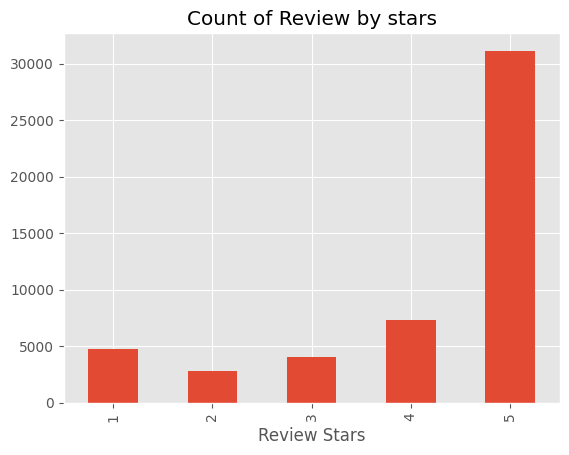

In [33]:

df['Text'][0]
ax = df['Score'].value_counts().sort_index().plot(kind = 'bar', title = 'Count of Review by stars')

ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [34]:
# Trying out an example

example = df['Text'][100]
print(example)

#  Word tokenize the review
tokens = nltk.word_tokenize(example)
print(tokens)

#  Part of speech tag the tokens
tags = nltk.pos_tag(tokens)
tags

The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.
['The', 'mouth', 'says', ',', '``', 'How', 'do', 'I', 'love', 'thee', ',', 'let', 'me', 'count', 'the', 'ways', '...', "''", '<', 'br', '/', '>', 'If', 'you', 'like', 'apple', 'products', 'a', 'must', 'have', 'item', '.', 'The', 'only', 'draw', 'back', ',', 'shipping', 'cost', '.', 'These', 'are', 'very', 'heavy', '.']


[('The', 'DT'),
 ('mouth', 'NN'),
 ('says', 'VBZ'),
 (',', ','),
 ('``', '``'),
 ('How', 'WRB'),
 ('do', 'VB'),
 ('I', 'PRP'),
 ('love', 'VB'),
 ('thee', 'NN'),
 (',', ','),
 ('let', 'VB'),
 ('me', 'PRP'),
 ('count', 'VB'),
 ('the', 'DT'),
 ('ways', 'NNS'),
 ('...', ':'),
 ("''", "''"),
 ('<', 'VBZ'),
 ('br', 'NN'),
 ('/', 'NNP'),
 ('>', 'NNP'),
 ('If', 'IN'),
 ('you', 'PRP'),
 ('like', 'VBP'),
 ('apple', 'NN'),
 ('products', 'NNS'),
 ('a', 'DT'),
 ('must', 'MD'),
 ('have', 'VB'),
 ('item', 'NN'),
 ('.', '.'),
 ('The', 'DT'),
 ('only', 'JJ'),
 ('draw', 'NN'),
 ('back', 'RB'),
 (',', ','),
 ('shipping', 'VBG'),
 ('cost', 'NN'),
 ('.', '.'),
 ('These', 'DT'),
 ('are', 'VBP'),
 ('very', 'RB'),
 ('heavy', 'JJ'),
 ('.', '.')]

## 1. VADER Sentiment Analysis

In [35]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [36]:
# Test polarity scores
print("Test random sentence")
score1 = sia.polarity_scores('Children are freakishly cute.')
print(score1)

print('\n')

print("Test dataset example")
print(sia.polarity_scores(example))
# vaders evaluates individual word sentiments rather than connection between the words and evaluating the sentence as a whole


Test random sentence
{'neg': 0.265, 'neu': 0.294, 'pos': 0.441, 'compound': 0.296}


Test dataset example
{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.7717}


In [37]:
from tqdm import tqdm

for i in tqdm(range(10)):
    pass
sia.polarity_scores(example)

100%|██████████| 10/10 [00:00<00:00, 184771.10it/s]


{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.7717}

In [38]:
# Run the polarity scores on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)




100%|██████████| 50000/50000 [00:13<00:00, 3637.03it/s]


In [39]:
# Transposing, indexing and left merging our results with the original dataframe
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how ='left')
print(vaders)



          Id    neg    neu    pos  compound   ProductId          UserId  \
0          1  0.000  0.695  0.305    0.9441  B001E4KFG0  A3SGXH7AUHU8GW   
1          2  0.138  0.862  0.000   -0.5664  B00813GRG4  A1D87F6ZCVE5NK   
2          3  0.091  0.754  0.155    0.8265  B000LQOCH0   ABXLMWJIXXAIN   
3          4  0.000  1.000  0.000    0.0000  B000UA0QIQ  A395BORC6FGVXV   
4          5  0.000  0.552  0.448    0.9468  B006K2ZZ7K  A1UQRSCLF8GW1T   
...      ...    ...    ...    ...       ...         ...             ...   
49995  49996  0.000  0.645  0.355    0.9623  B00430B73W   AKW867T7C6HF8   
49996  49997  0.000  0.499  0.501    0.9819  B00430B73W  A2PEHNEDMHOYTW   
49997  49998  0.154  0.647  0.198    0.2225  B00430B73W  A2QH2KF2IAB143   
49998  49999  0.052  0.808  0.141    0.4118  B00430B73W   AMX286UGXISMA   
49999  50000  0.000  0.570  0.430    0.8204  B00430B73W  A3042WJDYJ22S8   

                           ProfileName  HelpfulnessNumerator  \
0                           delmart

In [40]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## VADER results

/var/folders/cv/390tq0s54699hm5jjmwrgn500000gn/T/ipykernel_10723/720213032.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=vaders, x='Score', y='compound', palette='Set1')


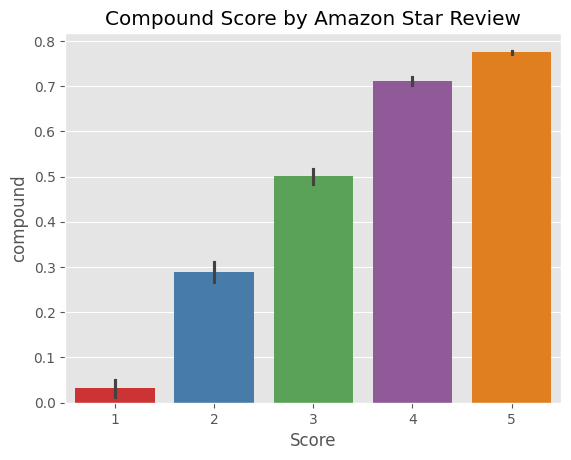

In [41]:
ax = sns.barplot(data=vaders, x='Score', y='compound', palette='Set1')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

VADER Result- Here, we can see the compound scores even for 1 star rated reviews are low yet positive

/var/folders/cv/390tq0s54699hm5jjmwrgn500000gn/T/ipykernel_10723/3161535701.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vaders, x='Score', y='pos', palette='Set1', ax = axs[0])
/var/folders/cv/390tq0s54699hm5jjmwrgn500000gn/T/ipykernel_10723/3161535701.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vaders, x='Score', y='neu', palette='Set1', ax = axs[1])
/var/folders/cv/390tq0s54699hm5jjmwrgn500000gn/T/ipykernel_10723/3161535701.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vaders, x='Score', y='neg', palett

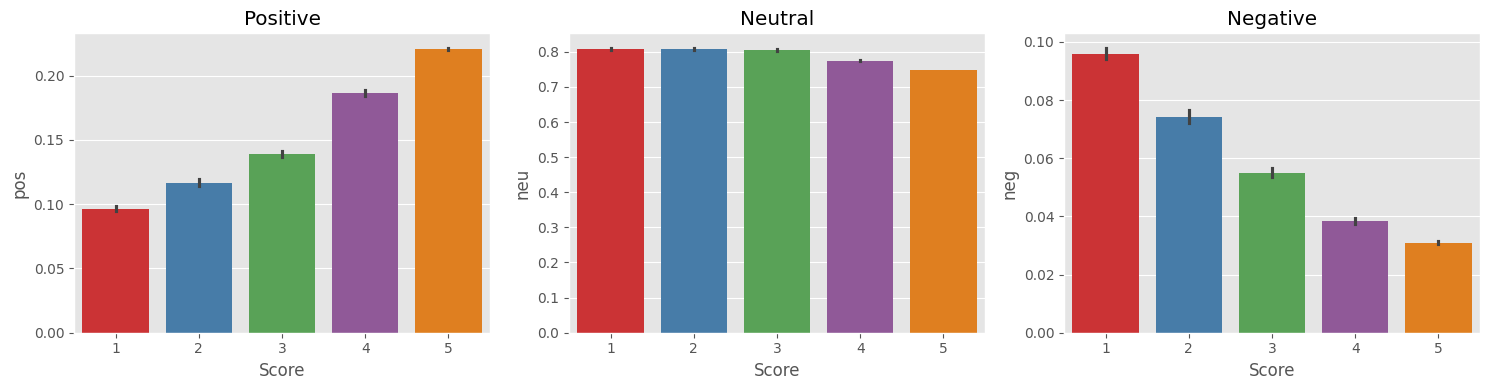

In [42]:
#  Comparing positive, neutral and negative degrees relation with the scores 

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=vaders, x='Score', y='pos', palette='Set1', ax = axs[0])
sns.barplot(data=vaders, x='Score', y='neu', palette='Set1', ax = axs[1])
sns.barplot(data=vaders, x='Score', y='neg', palette='Set1', ax = axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()
plt.show()

## RoBERTa Pretrained Model Sentiment Analysis

In [61]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
try:
    import torch
except ImportError:
    !pip install torch


In [59]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [45]:
# VADER results on example from data

print(example)
sia.polarity_scores(example)

The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.


{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.7717}

In [46]:
# RoBERTa results on example from data
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2],
        
    }
    return scores_dict

In [47]:
def rename_vader_res(res):
    vader_res = {}
    vader_res['vader_neg'] = res['neg']
    vader_res['vader_neu'] = res['neu']
    vader_res['vader_pos'] = res['pos']
    return vader_res

In [48]:
# Run the polarity scores on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_res0 = sia.polarity_scores(text)
        vader_res = {} # Store VADER results after renaming
        for key, value in vader_res0.items():
            vader_res[f"vader_{key}"] = value
        roberta_res = polarity_scores_roberta(text)
        combined_res = {**vader_res, **roberta_res}
        res[myid] = combined_res
    except (RuntimeError, IndexError) as e:
        print(f"Skipping id {myid} due to error: {e}")





  0%|          | 87/50000 [00:03<30:42, 27.09it/s]

Skipping id 83 due to error: The expanded size of the tensor (571) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 571].  Tensor sizes: [1, 514]


  0%|          | 190/50000 [00:07<27:59, 29.66it/s]

Skipping id 187 due to error: The expanded size of the tensor (546) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 546].  Tensor sizes: [1, 514]


  1%|          | 533/50000 [00:20<33:14, 24.80it/s]

Skipping id 529 due to error: The expanded size of the tensor (639) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 639].  Tensor sizes: [1, 514]


  1%|          | 545/50000 [00:20<29:13, 28.21it/s]

Skipping id 540 due to error: The expanded size of the tensor (1386) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1386].  Tensor sizes: [1, 514]


  1%|▏         | 749/50000 [00:29<40:30, 20.27it/s]

Skipping id 746 due to error: The expanded size of the tensor (705) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 705].  Tensor sizes: [1, 514]


  2%|▏         | 866/50000 [00:33<33:28, 24.46it/s]

Skipping id 863 due to error: The expanded size of the tensor (605) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 605].  Tensor sizes: [1, 514]


  2%|▏         | 1056/50000 [00:41<30:19, 26.90it/s]

Skipping id 1053 due to error: The expanded size of the tensor (789) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 789].  Tensor sizes: [1, 514]


  2%|▏         | 1075/50000 [00:42<30:02, 27.14it/s]

Skipping id 1070 due to error: The expanded size of the tensor (585) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 585].  Tensor sizes: [1, 514]


  2%|▏         | 1159/50000 [00:45<26:12, 31.06it/s]

Skipping id 1156 due to error: The expanded size of the tensor (597) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 597].  Tensor sizes: [1, 514]


  3%|▎         | 1324/50000 [00:51<32:37, 24.86it/s]

Skipping id 1321 due to error: The expanded size of the tensor (1246) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1246].  Tensor sizes: [1, 514]


  3%|▎         | 1378/50000 [00:53<31:36, 25.64it/s]

Skipping id 1375 due to error: The expanded size of the tensor (569) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 569].  Tensor sizes: [1, 514]


  3%|▎         | 1499/50000 [00:58<30:53, 26.17it/s]

Skipping id 1498 due to error: The expanded size of the tensor (1195) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1195].  Tensor sizes: [1, 514]


  3%|▎         | 1578/50000 [01:01<39:01, 20.68it/s]

Skipping id 1575 due to error: The expanded size of the tensor (555) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 555].  Tensor sizes: [1, 514]


  4%|▎         | 1800/50000 [01:10<23:18, 34.46it/s]

Skipping id 1796 due to error: The expanded size of the tensor (527) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 527].  Tensor sizes: [1, 514]


  4%|▎         | 1829/50000 [01:11<32:53, 24.41it/s]

Skipping id 1826 due to error: The expanded size of the tensor (976) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 976].  Tensor sizes: [1, 514]


  4%|▍         | 2171/50000 [01:25<31:17, 25.47it/s]

Skipping id 2169 due to error: The expanded size of the tensor (585) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 585].  Tensor sizes: [1, 514]


  4%|▍         | 2250/50000 [01:28<29:02, 27.40it/s]

Skipping id 2248 due to error: The expanded size of the tensor (1043) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1043].  Tensor sizes: [1, 514]


  5%|▍         | 2478/50000 [01:37<32:22, 24.46it/s]

Skipping id 2476 due to error: The expanded size of the tensor (550) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 550].  Tensor sizes: [1, 514]


  5%|▍         | 2494/50000 [01:38<31:24, 25.21it/s]

Skipping id 2492 due to error: The expanded size of the tensor (803) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 803].  Tensor sizes: [1, 514]


  5%|▌         | 2586/50000 [01:41<26:31, 29.80it/s]

Skipping id 2584 due to error: The expanded size of the tensor (879) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 879].  Tensor sizes: [1, 514]


  5%|▌         | 2613/50000 [01:42<34:09, 23.12it/s]

Skipping id 2610 due to error: The expanded size of the tensor (779) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 779].  Tensor sizes: [1, 514]


  6%|▌         | 2903/50000 [01:54<27:19, 28.73it/s]

Skipping id 2897 due to error: The expanded size of the tensor (603) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 603].  Tensor sizes: [1, 514]
Skipping id 2898 due to error: The expanded size of the tensor (740) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 740].  Tensor sizes: [1, 514]
Skipping id 2902 due to error: The expanded size of the tensor (538) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 538].  Tensor sizes: [1, 514]


  6%|▌         | 2931/50000 [01:55<30:01, 26.13it/s]

Skipping id 2928 due to error: The expanded size of the tensor (791) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 791].  Tensor sizes: [1, 514]


  6%|▌         | 2943/50000 [01:56<31:20, 25.03it/s]

Skipping id 2942 due to error: The expanded size of the tensor (1073) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1073].  Tensor sizes: [1, 514]
Skipping id 2944 due to error: The expanded size of the tensor (524) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 524].  Tensor sizes: [1, 514]
Skipping id 2947 due to error: The expanded size of the tensor (524) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 524].  Tensor sizes: [1, 514]
Skipping id 2948 due to error: The expanded size of the tensor (1073) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1073].  Tensor sizes: [1, 514]


  6%|▌         | 3026/50000 [01:59<28:01, 27.94it/s]

Skipping id 3022 due to error: The expanded size of the tensor (945) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 945].  Tensor sizes: [1, 514]
Skipping id 3023 due to error: The expanded size of the tensor (940) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 940].  Tensor sizes: [1, 514]
Skipping id 3025 due to error: The expanded size of the tensor (826) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 826].  Tensor sizes: [1, 514]


  7%|▋         | 3308/50000 [02:10<28:56, 26.88it/s]

Skipping id 3306 due to error: The expanded size of the tensor (860) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 860].  Tensor sizes: [1, 514]


  8%|▊         | 3792/50000 [02:29<28:39, 26.88it/s]

Skipping id 3788 due to error: The expanded size of the tensor (587) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 587].  Tensor sizes: [1, 514]


  8%|▊         | 3973/50000 [02:36<27:10, 28.23it/s]

Skipping id 3969 due to error: The expanded size of the tensor (551) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 551].  Tensor sizes: [1, 514]


  8%|▊         | 4109/50000 [02:42<32:15, 23.71it/s]

Skipping id 4107 due to error: The expanded size of the tensor (585) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 585].  Tensor sizes: [1, 514]
Skipping id 4110 due to error: The expanded size of the tensor (593) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 593].  Tensor sizes: [1, 514]


  9%|▊         | 4311/50000 [02:50<32:20, 23.54it/s]

Skipping id 4307 due to error: The expanded size of the tensor (886) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 886].  Tensor sizes: [1, 514]


  9%|▊         | 4321/50000 [02:51<32:12, 23.64it/s]

Skipping id 4316 due to error: The expanded size of the tensor (928) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 928].  Tensor sizes: [1, 514]


  9%|▉         | 4412/50000 [02:55<28:16, 26.87it/s]

Skipping id 4408 due to error: The expanded size of the tensor (793) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 793].  Tensor sizes: [1, 514]


  9%|▉         | 4485/50000 [02:57<24:41, 30.71it/s]

Skipping id 4483 due to error: The expanded size of the tensor (635) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 635].  Tensor sizes: [1, 514]


  9%|▉         | 4514/50000 [02:59<32:04, 23.64it/s]

Skipping id 4512 due to error: The expanded size of the tensor (540) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 540].  Tensor sizes: [1, 514]


  9%|▉         | 4554/50000 [03:00<30:41, 24.67it/s]

Skipping id 4553 due to error: The expanded size of the tensor (543) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 543].  Tensor sizes: [1, 514]


  9%|▉         | 4587/50000 [03:02<38:19, 19.75it/s]

Skipping id 4583 due to error: The expanded size of the tensor (826) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 826].  Tensor sizes: [1, 514]


 10%|█         | 5043/50000 [03:23<31:05, 24.10it/s]

Skipping id 5040 due to error: The expanded size of the tensor (572) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 572].  Tensor sizes: [1, 514]


 10%|█         | 5183/50000 [03:29<31:43, 23.55it/s]

Skipping id 5182 due to error: The expanded size of the tensor (521) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 521].  Tensor sizes: [1, 514]


 10%|█         | 5195/50000 [03:30<37:54, 19.70it/s]

Skipping id 5192 due to error: The expanded size of the tensor (521) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 521].  Tensor sizes: [1, 514]


 11%|█         | 5370/50000 [03:38<29:55, 24.86it/s]

Skipping id 5365 due to error: The expanded size of the tensor (658) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 658].  Tensor sizes: [1, 514]


 11%|█         | 5444/50000 [03:42<38:18, 19.38it/s]

Skipping id 5442 due to error: The expanded size of the tensor (682) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 682].  Tensor sizes: [1, 514]


 11%|█▏        | 5710/50000 [03:55<30:25, 24.26it/s]

Skipping id 5709 due to error: The expanded size of the tensor (754) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 754].  Tensor sizes: [1, 514]


 12%|█▏        | 6001/50000 [04:08<28:57, 25.33it/s]

Skipping id 5998 due to error: The expanded size of the tensor (1077) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1077].  Tensor sizes: [1, 514]


 12%|█▏        | 6004/50000 [04:09<29:52, 24.55it/s]

Skipping id 6003 due to error: The expanded size of the tensor (603) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 603].  Tensor sizes: [1, 514]


 12%|█▏        | 6010/50000 [04:09<32:34, 22.50it/s]

Skipping id 6007 due to error: The expanded size of the tensor (556) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 556].  Tensor sizes: [1, 514]


 12%|█▏        | 6110/50000 [04:13<30:30, 23.97it/s]

Skipping id 6106 due to error: The expanded size of the tensor (706) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 706].  Tensor sizes: [1, 514]


 12%|█▏        | 6239/50000 [04:19<30:53, 23.62it/s]

Skipping id 6234 due to error: The expanded size of the tensor (564) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 564].  Tensor sizes: [1, 514]


 13%|█▎        | 6561/50000 [04:34<32:37, 22.19it/s]

Skipping id 6558 due to error: The expanded size of the tensor (531) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 531].  Tensor sizes: [1, 514]


 13%|█▎        | 6653/50000 [04:38<41:31, 17.40it/s]

Skipping id 6651 due to error: The expanded size of the tensor (924) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 924].  Tensor sizes: [1, 514]


 14%|█▎        | 6801/50000 [04:46<32:59, 21.82it/s]

Skipping id 6798 due to error: The expanded size of the tensor (629) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 629].  Tensor sizes: [1, 514]


 14%|█▎        | 6840/50000 [04:49<39:49, 18.06it/s]

Skipping id 6838 due to error: The expanded size of the tensor (523) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 523].  Tensor sizes: [1, 514]


 14%|█▎        | 6851/50000 [04:49<37:24, 19.23it/s]

Skipping id 6850 due to error: The expanded size of the tensor (1149) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1149].  Tensor sizes: [1, 514]


 14%|█▍        | 6889/50000 [04:51<28:07, 25.54it/s]

Skipping id 6886 due to error: The expanded size of the tensor (631) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 631].  Tensor sizes: [1, 514]


 14%|█▍        | 6907/50000 [04:52<35:08, 20.44it/s]

Skipping id 6905 due to error: The expanded size of the tensor (544) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 544].  Tensor sizes: [1, 514]


 14%|█▍        | 6957/50000 [04:55<33:42, 21.29it/s]

Skipping id 6955 due to error: The expanded size of the tensor (617) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 617].  Tensor sizes: [1, 514]


 14%|█▍        | 7080/50000 [05:00<33:29, 21.36it/s]

Skipping id 7077 due to error: The expanded size of the tensor (717) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 717].  Tensor sizes: [1, 514]


 14%|█▍        | 7089/50000 [05:00<30:26, 23.50it/s]

Skipping id 7088 due to error: The expanded size of the tensor (603) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 603].  Tensor sizes: [1, 514]


 14%|█▍        | 7204/50000 [05:05<26:58, 26.44it/s]

Skipping id 7201 due to error: The expanded size of the tensor (705) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 705].  Tensor sizes: [1, 514]


 15%|█▌        | 7607/50000 [05:22<27:58, 25.25it/s]

Skipping id 7604 due to error: The expanded size of the tensor (531) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 531].  Tensor sizes: [1, 514]
Skipping id 7608 due to error: The expanded size of the tensor (710) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 710].  Tensor sizes: [1, 514]


 15%|█▌        | 7672/50000 [05:25<25:59, 27.13it/s]

Skipping id 7671 due to error: The expanded size of the tensor (617) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 617].  Tensor sizes: [1, 514]


 15%|█▌        | 7703/50000 [05:26<31:57, 22.06it/s]

Skipping id 7701 due to error: The expanded size of the tensor (628) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 628].  Tensor sizes: [1, 514]


 16%|█▌        | 7811/50000 [05:31<26:07, 26.91it/s]

Skipping id 7810 due to error: The expanded size of the tensor (788) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 788].  Tensor sizes: [1, 514]


 16%|█▌        | 7910/50000 [05:35<33:04, 21.21it/s]

Skipping id 7907 due to error: The expanded size of the tensor (672) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 672].  Tensor sizes: [1, 514]


 16%|█▌        | 8081/50000 [05:43<27:02, 25.83it/s]

Skipping id 8077 due to error: The expanded size of the tensor (1259) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1259].  Tensor sizes: [1, 514]


 16%|█▋        | 8135/50000 [05:45<26:01, 26.81it/s]

Skipping id 8131 due to error: The expanded size of the tensor (584) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 584].  Tensor sizes: [1, 514]


 17%|█▋        | 8270/50000 [05:51<26:04, 26.68it/s]

Skipping id 8266 due to error: The expanded size of the tensor (524) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 524].  Tensor sizes: [1, 514]


 17%|█▋        | 8740/50000 [06:10<27:05, 25.38it/s]

Skipping id 8740 due to error: The expanded size of the tensor (600) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 600].  Tensor sizes: [1, 514]


 18%|█▊        | 8759/50000 [06:11<28:06, 24.45it/s]

Skipping id 8757 due to error: The expanded size of the tensor (2017) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 2017].  Tensor sizes: [1, 514]


 18%|█▊        | 8938/50000 [06:18<23:59, 28.53it/s]

Skipping id 8935 due to error: The expanded size of the tensor (587) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 587].  Tensor sizes: [1, 514]


 19%|█▉        | 9593/50000 [06:45<29:24, 22.90it/s]

Skipping id 9590 due to error: The expanded size of the tensor (530) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 530].  Tensor sizes: [1, 514]


 20%|█▉        | 9853/50000 [06:56<29:52, 22.40it/s]

Skipping id 9850 due to error: The expanded size of the tensor (2149) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 2149].  Tensor sizes: [1, 514]


 20%|█▉        | 9885/50000 [06:58<25:11, 26.55it/s]

Skipping id 9881 due to error: The expanded size of the tensor (612) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 612].  Tensor sizes: [1, 514]


 20%|█▉        | 9913/50000 [06:59<30:55, 21.60it/s]

Skipping id 9910 due to error: The expanded size of the tensor (636) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 636].  Tensor sizes: [1, 514]


 20%|█▉        | 9925/50000 [07:00<31:37, 21.12it/s]

Skipping id 9923 due to error: The expanded size of the tensor (572) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 572].  Tensor sizes: [1, 514]


 20%|██        | 10006/50000 [07:03<29:29, 22.61it/s]

Skipping id 10002 due to error: The expanded size of the tensor (790) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 790].  Tensor sizes: [1, 514]
Skipping id 10005 due to error: The expanded size of the tensor (2365) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 2365].  Tensor sizes: [1, 514]


 20%|██        | 10035/50000 [07:04<25:46, 25.84it/s]

Skipping id 10031 due to error: The expanded size of the tensor (638) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 638].  Tensor sizes: [1, 514]


 21%|██        | 10554/50000 [07:26<29:32, 22.25it/s]

Skipping id 10550 due to error: The expanded size of the tensor (542) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 542].  Tensor sizes: [1, 514]


 22%|██▏       | 10840/50000 [07:38<26:29, 24.63it/s]

Skipping id 10837 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]


 22%|██▏       | 10867/50000 [07:39<20:18, 32.11it/s]

Skipping id 10861 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 10862 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 10863 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 10864 due to error: The expanded size of the tensor (706) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 706].  Tensor sizes: [1, 514]


 22%|██▏       | 10888/50000 [07:40<22:15, 29.29it/s]

Skipping id 10885 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]


 22%|██▏       | 10928/50000 [07:42<25:24, 25.63it/s]

Skipping id 10924 due to error: The expanded size of the tensor (1034) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1034].  Tensor sizes: [1, 514]


 22%|██▏       | 10951/50000 [07:43<23:51, 27.28it/s]

Skipping id 10946 due to error: The expanded size of the tensor (577) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 577].  Tensor sizes: [1, 514]


 22%|██▏       | 10971/50000 [07:44<32:13, 20.18it/s]

Skipping id 10969 due to error: The expanded size of the tensor (584) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 584].  Tensor sizes: [1, 514]


 22%|██▏       | 11117/50000 [07:50<23:20, 27.77it/s]

Skipping id 11114 due to error: The expanded size of the tensor (564) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 564].  Tensor sizes: [1, 514]


 22%|██▏       | 11241/50000 [07:55<20:59, 30.78it/s]

Skipping id 11238 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 11239 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]


 22%|██▏       | 11249/50000 [07:56<23:50, 27.10it/s]

Skipping id 11245 due to error: The expanded size of the tensor (680) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 680].  Tensor sizes: [1, 514]


 23%|██▎       | 11306/50000 [07:58<25:12, 25.58it/s]

Skipping id 11302 due to error: The expanded size of the tensor (535) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 535].  Tensor sizes: [1, 514]


 23%|██▎       | 11379/50000 [08:01<26:26, 24.34it/s]

Skipping id 11376 due to error: index out of range in self


 23%|██▎       | 11476/50000 [08:05<23:44, 27.04it/s]

Skipping id 11471 due to error: The expanded size of the tensor (617) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 617].  Tensor sizes: [1, 514]


 23%|██▎       | 11524/50000 [08:07<26:17, 24.39it/s]

Skipping id 11520 due to error: The expanded size of the tensor (903) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 903].  Tensor sizes: [1, 514]


 23%|██▎       | 11586/50000 [08:10<25:59, 24.64it/s]

Skipping id 11582 due to error: The expanded size of the tensor (569) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 569].  Tensor sizes: [1, 514]


 23%|██▎       | 11730/50000 [08:16<25:25, 25.08it/s]

Skipping id 11726 due to error: The expanded size of the tensor (568) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 568].  Tensor sizes: [1, 514]


 24%|██▎       | 11807/50000 [08:19<28:10, 22.60it/s]

Skipping id 11803 due to error: The expanded size of the tensor (780) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 780].  Tensor sizes: [1, 514]


 24%|██▍       | 11881/50000 [08:22<22:05, 28.75it/s]

Skipping id 11876 due to error: The expanded size of the tensor (530) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 530].  Tensor sizes: [1, 514]


 24%|██▍       | 11944/50000 [08:25<25:17, 25.07it/s]

Skipping id 11939 due to error: The expanded size of the tensor (685) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 685].  Tensor sizes: [1, 514]


 24%|██▍       | 12012/50000 [08:28<23:47, 26.61it/s]

Skipping id 12009 due to error: The expanded size of the tensor (622) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 622].  Tensor sizes: [1, 514]


 24%|██▍       | 12047/50000 [08:29<27:18, 23.16it/s]

Skipping id 12044 due to error: The expanded size of the tensor (591) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 591].  Tensor sizes: [1, 514]


 24%|██▍       | 12051/50000 [08:29<27:42, 22.82it/s]

Skipping id 12050 due to error: The expanded size of the tensor (675) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 675].  Tensor sizes: [1, 514]


 24%|██▍       | 12230/50000 [08:37<26:23, 23.85it/s]

Skipping id 12228 due to error: The expanded size of the tensor (664) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 664].  Tensor sizes: [1, 514]


 24%|██▍       | 12242/50000 [08:38<27:53, 22.56it/s]

Skipping id 12241 due to error: The expanded size of the tensor (719) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 719].  Tensor sizes: [1, 514]


 25%|██▍       | 12266/50000 [08:39<26:23, 23.83it/s]

Skipping id 12264 due to error: The expanded size of the tensor (582) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 582].  Tensor sizes: [1, 514]


 25%|██▍       | 12307/50000 [08:40<27:36, 22.75it/s]

Skipping id 12304 due to error: The expanded size of the tensor (627) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 627].  Tensor sizes: [1, 514]


 25%|██▌       | 12737/50000 [08:59<28:57, 21.45it/s]

Skipping id 12736 due to error: The expanded size of the tensor (515) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 515].  Tensor sizes: [1, 514]


 26%|██▌       | 12826/50000 [09:03<23:21, 26.52it/s]

Skipping id 12824 due to error: The expanded size of the tensor (728) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 728].  Tensor sizes: [1, 514]


 26%|██▌       | 13069/50000 [09:13<29:11, 21.08it/s]

Skipping id 13065 due to error: The expanded size of the tensor (775) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 775].  Tensor sizes: [1, 514]


 26%|██▌       | 13099/50000 [09:14<27:52, 22.06it/s]

Skipping id 13095 due to error: The expanded size of the tensor (750) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 750].  Tensor sizes: [1, 514]


 26%|██▋       | 13169/50000 [09:18<29:53, 20.54it/s]

Skipping id 13166 due to error: The expanded size of the tensor (738) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 738].  Tensor sizes: [1, 514]


 26%|██▋       | 13185/50000 [09:19<29:14, 20.99it/s]

Skipping id 13184 due to error: The expanded size of the tensor (584) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 584].  Tensor sizes: [1, 514]


 26%|██▋       | 13201/50000 [09:20<31:40, 19.36it/s]

Skipping id 13200 due to error: The expanded size of the tensor (678) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 678].  Tensor sizes: [1, 514]


 27%|██▋       | 13283/50000 [09:23<22:19, 27.40it/s]

Skipping id 13280 due to error: The expanded size of the tensor (710) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 710].  Tensor sizes: [1, 514]
Skipping id 13282 due to error: The expanded size of the tensor (566) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 566].  Tensor sizes: [1, 514]


 27%|██▋       | 13296/50000 [09:24<25:59, 23.53it/s]

Skipping id 13294 due to error: index out of range in self


 27%|██▋       | 13522/50000 [09:35<22:22, 27.17it/s]

Skipping id 13518 due to error: The expanded size of the tensor (610) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 610].  Tensor sizes: [1, 514]


 27%|██▋       | 13719/50000 [09:43<25:08, 24.05it/s]

Skipping id 13715 due to error: The expanded size of the tensor (567) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 567].  Tensor sizes: [1, 514]


 28%|██▊       | 13901/50000 [09:51<23:53, 25.19it/s]

Skipping id 13898 due to error: The expanded size of the tensor (523) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 523].  Tensor sizes: [1, 514]


 28%|██▊       | 14014/50000 [09:56<27:37, 21.71it/s]

Skipping id 14012 due to error: The expanded size of the tensor (606) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 606].  Tensor sizes: [1, 514]


 28%|██▊       | 14044/50000 [09:58<34:19, 17.46it/s]

Skipping id 14042 due to error: The expanded size of the tensor (569) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 569].  Tensor sizes: [1, 514]
Skipping id 14046 due to error: The expanded size of the tensor (742) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 742].  Tensor sizes: [1, 514]


 28%|██▊       | 14063/50000 [09:59<37:17, 16.06it/s]

Skipping id 14062 due to error: The expanded size of the tensor (650) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 650].  Tensor sizes: [1, 514]


 28%|██▊       | 14078/50000 [10:00<36:50, 16.25it/s]

Skipping id 14077 due to error: The expanded size of the tensor (547) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 547].  Tensor sizes: [1, 514]


 28%|██▊       | 14093/50000 [10:01<42:16, 14.15it/s]

Skipping id 14092 due to error: The expanded size of the tensor (658) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 658].  Tensor sizes: [1, 514]


 28%|██▊       | 14101/50000 [10:01<30:41, 19.49it/s]

Skipping id 14098 due to error: The expanded size of the tensor (881) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 881].  Tensor sizes: [1, 514]
Skipping id 14099 due to error: The expanded size of the tensor (646) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 646].  Tensor sizes: [1, 514]


 28%|██▊       | 14113/50000 [10:02<35:51, 16.68it/s]

Skipping id 14111 due to error: The expanded size of the tensor (640) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 640].  Tensor sizes: [1, 514]


 28%|██▊       | 14132/50000 [10:03<31:54, 18.74it/s]

Skipping id 14128 due to error: The expanded size of the tensor (686) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 686].  Tensor sizes: [1, 514]


 28%|██▊       | 14158/50000 [10:05<30:50, 19.37it/s]

Skipping id 14157 due to error: The expanded size of the tensor (537) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 537].  Tensor sizes: [1, 514]


 28%|██▊       | 14208/50000 [10:08<36:46, 16.22it/s]

Skipping id 14207 due to error: The expanded size of the tensor (619) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 619].  Tensor sizes: [1, 514]


 29%|██▊       | 14256/50000 [10:11<31:53, 18.68it/s]

Skipping id 14254 due to error: The expanded size of the tensor (647) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 647].  Tensor sizes: [1, 514]


 29%|██▊       | 14275/50000 [10:12<29:57, 19.87it/s]

Skipping id 14273 due to error: The expanded size of the tensor (528) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 528].  Tensor sizes: [1, 514]


 30%|██▉       | 14765/50000 [10:34<22:48, 25.74it/s]

Skipping id 14764 due to error: The expanded size of the tensor (850) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 850].  Tensor sizes: [1, 514]


 30%|██▉       | 14790/50000 [10:36<27:19, 21.48it/s]

Skipping id 14785 due to error: The expanded size of the tensor (571) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 571].  Tensor sizes: [1, 514]


 30%|██▉       | 14899/50000 [10:41<24:41, 23.69it/s]

Skipping id 14896 due to error: The expanded size of the tensor (525) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 525].  Tensor sizes: [1, 514]


 30%|██▉       | 14915/50000 [10:42<25:30, 22.92it/s]

Skipping id 14914 due to error: The expanded size of the tensor (882) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 882].  Tensor sizes: [1, 514]


 30%|███       | 15217/50000 [10:55<28:23, 20.42it/s]

Skipping id 15217 due to error: The expanded size of the tensor (546) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 546].  Tensor sizes: [1, 514]


 30%|███       | 15223/50000 [10:55<32:49, 17.65it/s]

Skipping id 15222 due to error: The expanded size of the tensor (561) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 561].  Tensor sizes: [1, 514]


 31%|███       | 15405/50000 [11:06<25:22, 22.72it/s]

Skipping id 15401 due to error: The expanded size of the tensor (640) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 640].  Tensor sizes: [1, 514]


 31%|███▏      | 15708/50000 [11:19<23:14, 24.59it/s]

Skipping id 15704 due to error: The expanded size of the tensor (557) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 557].  Tensor sizes: [1, 514]


 32%|███▏      | 15770/50000 [11:22<20:42, 27.54it/s]

Skipping id 15765 due to error: The expanded size of the tensor (712) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 712].  Tensor sizes: [1, 514]


 32%|███▏      | 15832/50000 [11:24<24:09, 23.57it/s]

Skipping id 15829 due to error: The expanded size of the tensor (732) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 732].  Tensor sizes: [1, 514]


 32%|███▏      | 16056/50000 [11:34<27:07, 20.86it/s]

Skipping id 16054 due to error: The expanded size of the tensor (732) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 732].  Tensor sizes: [1, 514]
Skipping id 16056 due to error: The expanded size of the tensor (811) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 811].  Tensor sizes: [1, 514]


 32%|███▏      | 16219/50000 [11:42<22:16, 25.28it/s]

Skipping id 16215 due to error: The expanded size of the tensor (569) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 569].  Tensor sizes: [1, 514]


 33%|███▎      | 16548/50000 [11:56<24:04, 23.16it/s]

Skipping id 16544 due to error: index out of range in self


 34%|███▎      | 16750/50000 [12:07<27:54, 19.86it/s]

Skipping id 16748 due to error: The expanded size of the tensor (890) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 890].  Tensor sizes: [1, 514]


 34%|███▎      | 16756/50000 [12:07<26:51, 20.63it/s]

Skipping id 16754 due to error: The expanded size of the tensor (925) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 925].  Tensor sizes: [1, 514]


 34%|███▎      | 16836/50000 [12:12<30:33, 18.09it/s]

Skipping id 16835 due to error: The expanded size of the tensor (1123) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1123].  Tensor sizes: [1, 514]


 34%|███▎      | 16864/50000 [12:13<23:19, 23.68it/s]

Skipping id 16860 due to error: The expanded size of the tensor (1170) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1170].  Tensor sizes: [1, 514]


 34%|███▍      | 17018/50000 [12:21<27:08, 20.25it/s]

Skipping id 17014 due to error: The expanded size of the tensor (1040) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1040].  Tensor sizes: [1, 514]


 34%|███▍      | 17084/50000 [12:24<23:23, 23.45it/s]

Skipping id 17083 due to error: The expanded size of the tensor (876) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 876].  Tensor sizes: [1, 514]


 34%|███▍      | 17151/50000 [12:27<19:25, 28.18it/s]

Skipping id 17148 due to error: The expanded size of the tensor (632) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 632].  Tensor sizes: [1, 514]
Skipping id 17149 due to error: The expanded size of the tensor (663) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 663].  Tensor sizes: [1, 514]


 35%|███▍      | 17263/50000 [12:32<25:31, 21.38it/s]

Skipping id 17260 due to error: The expanded size of the tensor (526) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 526].  Tensor sizes: [1, 514]


 35%|███▌      | 17732/50000 [12:52<26:00, 20.68it/s]

Skipping id 17731 due to error: The expanded size of the tensor (691) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 691].  Tensor sizes: [1, 514]


 36%|███▌      | 17942/50000 [13:02<21:56, 24.36it/s]

Skipping id 17939 due to error: The expanded size of the tensor (645) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 645].  Tensor sizes: [1, 514]


 36%|███▌      | 18031/50000 [13:05<24:06, 22.10it/s]

Skipping id 18028 due to error: The expanded size of the tensor (674) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 674].  Tensor sizes: [1, 514]


 36%|███▋      | 18196/50000 [13:13<23:01, 23.02it/s]

Skipping id 18192 due to error: The expanded size of the tensor (1234) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1234].  Tensor sizes: [1, 514]


 36%|███▋      | 18248/50000 [13:15<19:19, 27.38it/s]

Skipping id 18245 due to error: The expanded size of the tensor (639) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 639].  Tensor sizes: [1, 514]


 37%|███▋      | 18324/50000 [13:19<20:39, 25.56it/s]

Skipping id 18321 due to error: The expanded size of the tensor (688) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 688].  Tensor sizes: [1, 514]


 37%|███▋      | 18345/50000 [13:20<24:30, 21.53it/s]

Skipping id 18343 due to error: The expanded size of the tensor (730) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 730].  Tensor sizes: [1, 514]


 37%|███▋      | 18495/50000 [13:26<22:09, 23.70it/s]

Skipping id 18491 due to error: The expanded size of the tensor (743) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 743].  Tensor sizes: [1, 514]


 37%|███▋      | 18525/50000 [13:28<22:52, 22.94it/s]

Skipping id 18523 due to error: The expanded size of the tensor (707) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 707].  Tensor sizes: [1, 514]


 37%|███▋      | 18561/50000 [13:29<22:45, 23.02it/s]

Skipping id 18559 due to error: The expanded size of the tensor (581) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 581].  Tensor sizes: [1, 514]


 37%|███▋      | 18639/50000 [13:33<30:39, 17.05it/s]

Skipping id 18638 due to error: The expanded size of the tensor (783) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 783].  Tensor sizes: [1, 514]


 38%|███▊      | 18762/50000 [13:38<23:48, 21.86it/s]

Skipping id 18760 due to error: The expanded size of the tensor (575) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 575].  Tensor sizes: [1, 514]


 38%|███▊      | 18867/50000 [13:44<25:46, 20.14it/s]

Skipping id 18865 due to error: The expanded size of the tensor (597) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 597].  Tensor sizes: [1, 514]


 38%|███▊      | 18873/50000 [13:44<25:14, 20.55it/s]

Skipping id 18870 due to error: The expanded size of the tensor (549) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 549].  Tensor sizes: [1, 514]


 38%|███▊      | 18880/50000 [13:44<22:10, 23.38it/s]

Skipping id 18877 due to error: The expanded size of the tensor (624) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 624].  Tensor sizes: [1, 514]


 38%|███▊      | 18951/50000 [13:48<24:20, 21.26it/s]

Skipping id 18950 due to error: The expanded size of the tensor (521) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 521].  Tensor sizes: [1, 514]


 38%|███▊      | 19093/50000 [13:54<21:24, 24.06it/s]

Skipping id 19090 due to error: The expanded size of the tensor (533) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 533].  Tensor sizes: [1, 514]


 38%|███▊      | 19139/50000 [13:56<20:22, 25.24it/s]

Skipping id 19134 due to error: The expanded size of the tensor (618) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 618].  Tensor sizes: [1, 514]


 39%|███▉      | 19412/50000 [14:09<19:46, 25.78it/s]

Skipping id 19408 due to error: The expanded size of the tensor (549) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 549].  Tensor sizes: [1, 514]


 39%|███▉      | 19526/50000 [14:15<23:08, 21.95it/s]

Skipping id 19523 due to error: The expanded size of the tensor (531) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 531].  Tensor sizes: [1, 514]


 39%|███▉      | 19547/50000 [14:16<26:36, 19.08it/s]

Skipping id 19544 due to error: The expanded size of the tensor (589) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 589].  Tensor sizes: [1, 514]


 39%|███▉      | 19561/50000 [14:16<26:59, 18.80it/s]

Skipping id 19560 due to error: The expanded size of the tensor (706) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 706].  Tensor sizes: [1, 514]


 39%|███▉      | 19570/50000 [14:17<27:20, 18.55it/s]

Skipping id 19568 due to error: The expanded size of the tensor (1349) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1349].  Tensor sizes: [1, 514]
Skipping id 19571 due to error: The expanded size of the tensor (794) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 794].  Tensor sizes: [1, 514]


 39%|███▉      | 19573/50000 [14:17<25:17, 20.05it/s]

Skipping id 19574 due to error: The expanded size of the tensor (566) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 566].  Tensor sizes: [1, 514]


 39%|███▉      | 19589/50000 [14:18<29:23, 17.24it/s]

Skipping id 19588 due to error: The expanded size of the tensor (572) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 572].  Tensor sizes: [1, 514]


 39%|███▉      | 19613/50000 [14:19<25:50, 19.59it/s]

Skipping id 19610 due to error: The expanded size of the tensor (665) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 665].  Tensor sizes: [1, 514]


 39%|███▉      | 19648/50000 [14:21<26:04, 19.41it/s]

Skipping id 19646 due to error: The expanded size of the tensor (875) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 875].  Tensor sizes: [1, 514]


 40%|███▉      | 19831/50000 [14:30<26:32, 18.94it/s]

Skipping id 19828 due to error: The expanded size of the tensor (1347) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1347].  Tensor sizes: [1, 514]


 40%|███▉      | 19851/50000 [14:31<26:19, 19.09it/s]

Skipping id 19849 due to error: The expanded size of the tensor (859) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 859].  Tensor sizes: [1, 514]


 40%|███▉      | 19856/50000 [14:31<25:19, 19.84it/s]

Skipping id 19854 due to error: The expanded size of the tensor (576) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 576].  Tensor sizes: [1, 514]


 40%|████      | 20236/50000 [14:48<17:53, 27.72it/s]

Skipping id 20230 due to error: The expanded size of the tensor (535) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 535].  Tensor sizes: [1, 514]


 41%|████      | 20347/50000 [14:55<24:55, 19.83it/s]

Skipping id 20344 due to error: The expanded size of the tensor (755) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 755].  Tensor sizes: [1, 514]
Skipping id 20345 due to error: The expanded size of the tensor (640) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 640].  Tensor sizes: [1, 514]


 41%|████      | 20361/50000 [14:56<26:06, 18.92it/s]

Skipping id 20358 due to error: The expanded size of the tensor (649) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 649].  Tensor sizes: [1, 514]


 41%|████      | 20400/50000 [14:58<31:54, 15.46it/s]

Skipping id 20398 due to error: The expanded size of the tensor (765) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 765].  Tensor sizes: [1, 514]


 41%|████      | 20415/50000 [14:59<29:04, 16.96it/s]

Skipping id 20414 due to error: The expanded size of the tensor (652) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 652].  Tensor sizes: [1, 514]


 41%|████      | 20417/50000 [14:59<33:23, 14.76it/s]

Skipping id 20418 due to error: The expanded size of the tensor (805) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 805].  Tensor sizes: [1, 514]
Skipping id 20420 due to error: The expanded size of the tensor (1793) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1793].  Tensor sizes: [1, 514]


 41%|████      | 20429/50000 [15:00<25:48, 19.10it/s]

Skipping id 20428 due to error: The expanded size of the tensor (552) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 552].  Tensor sizes: [1, 514]


 41%|████      | 20436/50000 [15:00<28:27, 17.32it/s]

Skipping id 20434 due to error: The expanded size of the tensor (798) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 798].  Tensor sizes: [1, 514]
Skipping id 20435 due to error: The expanded size of the tensor (593) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 593].  Tensor sizes: [1, 514]
Skipping id 20437 due to error: The expanded size of the tensor (926) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 926].  Tensor sizes: [1, 514]
Skipping id 20438 due to error: The expanded size of the tensor (827) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 827].  Tensor sizes: [1, 514]


 41%|████      | 20463/50000 [15:02<25:57, 18.96it/s]

Skipping id 20461 due to error: The expanded size of the tensor (866) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 866].  Tensor sizes: [1, 514]


 41%|████      | 20486/50000 [15:03<29:25, 16.72it/s]

Skipping id 20484 due to error: The expanded size of the tensor (881) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 881].  Tensor sizes: [1, 514]


 41%|████      | 20498/50000 [15:04<25:21, 19.39it/s]

Skipping id 20497 due to error: The expanded size of the tensor (656) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 656].  Tensor sizes: [1, 514]


 41%|████      | 20505/50000 [15:04<22:28, 21.87it/s]

Skipping id 20502 due to error: The expanded size of the tensor (541) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 541].  Tensor sizes: [1, 514]
Skipping id 20503 due to error: The expanded size of the tensor (693) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 693].  Tensor sizes: [1, 514]


 41%|████      | 20515/50000 [15:05<20:43, 23.71it/s]

Skipping id 20511 due to error: The expanded size of the tensor (571) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 571].  Tensor sizes: [1, 514]


 41%|████      | 20534/50000 [15:05<19:14, 25.52it/s]

Skipping id 20531 due to error: The expanded size of the tensor (674) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 674].  Tensor sizes: [1, 514]
Skipping id 20536 due to error: The expanded size of the tensor (658) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 658].  Tensor sizes: [1, 514]


 41%|████▏     | 20744/50000 [15:15<21:20, 22.85it/s]

Skipping id 20741 due to error: The expanded size of the tensor (522) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 522].  Tensor sizes: [1, 514]
Skipping id 20742 due to error: The expanded size of the tensor (531) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 531].  Tensor sizes: [1, 514]


 42%|████▏     | 20921/50000 [15:23<19:58, 24.27it/s]

Skipping id 20918 due to error: The expanded size of the tensor (603) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 603].  Tensor sizes: [1, 514]


 42%|████▏     | 20934/50000 [15:23<18:05, 26.77it/s]

Skipping id 20931 due to error: The expanded size of the tensor (599) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 599].  Tensor sizes: [1, 514]


 42%|████▏     | 21118/50000 [15:31<17:59, 26.77it/s]

Skipping id 21117 due to error: The expanded size of the tensor (638) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 638].  Tensor sizes: [1, 514]


 43%|████▎     | 21628/50000 [15:52<20:06, 23.52it/s]

Skipping id 21626 due to error: The expanded size of the tensor (902) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 902].  Tensor sizes: [1, 514]


 43%|████▎     | 21717/50000 [15:56<21:45, 21.66it/s]

Skipping id 21714 due to error: The expanded size of the tensor (934) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 934].  Tensor sizes: [1, 514]


 44%|████▎     | 21824/50000 [16:01<20:41, 22.69it/s]

Skipping id 21820 due to error: The expanded size of the tensor (562) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 562].  Tensor sizes: [1, 514]


 44%|████▍     | 21942/50000 [16:07<24:37, 18.99it/s]

Skipping id 21940 due to error: The expanded size of the tensor (577) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 577].  Tensor sizes: [1, 514]


 44%|████▍     | 22008/50000 [16:11<24:02, 19.41it/s]

Skipping id 22005 due to error: The expanded size of the tensor (522) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 522].  Tensor sizes: [1, 514]


 45%|████▍     | 22258/50000 [16:23<20:22, 22.70it/s]

Skipping id 22256 due to error: The expanded size of the tensor (536) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 536].  Tensor sizes: [1, 514]


 45%|████▍     | 22301/50000 [16:26<19:09, 24.10it/s]

Skipping id 22299 due to error: The expanded size of the tensor (1089) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1089].  Tensor sizes: [1, 514]


 45%|████▍     | 22483/50000 [16:34<17:40, 25.96it/s]

Skipping id 22479 due to error: The expanded size of the tensor (998) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 998].  Tensor sizes: [1, 514]
Skipping id 22484 due to error: The expanded size of the tensor (1046) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1046].  Tensor sizes: [1, 514]


 45%|████▍     | 22489/50000 [16:34<17:58, 25.52it/s]

Skipping id 22487 due to error: The expanded size of the tensor (989) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 989].  Tensor sizes: [1, 514]


 46%|████▌     | 22956/50000 [16:56<21:24, 21.05it/s]

Skipping id 22952 due to error: The expanded size of the tensor (545) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 545].  Tensor sizes: [1, 514]


 46%|████▌     | 22972/50000 [16:57<20:32, 21.93it/s]

Skipping id 22971 due to error: The expanded size of the tensor (626) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 626].  Tensor sizes: [1, 514]


 46%|████▌     | 23020/50000 [16:59<21:52, 20.56it/s]

Skipping id 23017 due to error: The expanded size of the tensor (712) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 712].  Tensor sizes: [1, 514]


 46%|████▌     | 23039/50000 [17:00<19:08, 23.47it/s]

Skipping id 23036 due to error: The expanded size of the tensor (538) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 538].  Tensor sizes: [1, 514]


 46%|████▌     | 23091/50000 [17:03<24:11, 18.53it/s]

Skipping id 23088 due to error: The expanded size of the tensor (1155) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1155].  Tensor sizes: [1, 514]


 46%|████▌     | 23112/50000 [17:04<24:05, 18.61it/s]

Skipping id 23110 due to error: The expanded size of the tensor (523) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 523].  Tensor sizes: [1, 514]


 46%|████▋     | 23144/50000 [17:06<20:19, 22.02it/s]

Skipping id 23140 due to error: The expanded size of the tensor (691) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 691].  Tensor sizes: [1, 514]
Skipping id 23143 due to error: The expanded size of the tensor (690) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 690].  Tensor sizes: [1, 514]


 46%|████▋     | 23202/50000 [17:10<26:43, 16.71it/s]

Skipping id 23201 due to error: The expanded size of the tensor (548) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 548].  Tensor sizes: [1, 514]


 47%|████▋     | 23419/50000 [17:21<22:26, 19.74it/s]

Skipping id 23417 due to error: The expanded size of the tensor (819) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 819].  Tensor sizes: [1, 514]


 47%|████▋     | 23428/50000 [17:21<23:34, 18.78it/s]

Skipping id 23425 due to error: The expanded size of the tensor (649) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 649].  Tensor sizes: [1, 514]
Skipping id 23429 due to error: The expanded size of the tensor (869) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 869].  Tensor sizes: [1, 514]


 47%|████▋     | 23666/50000 [17:32<16:53, 25.99it/s]

Skipping id 23663 due to error: The expanded size of the tensor (542) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 542].  Tensor sizes: [1, 514]


 47%|████▋     | 23704/50000 [17:34<16:42, 26.23it/s]

Skipping id 23700 due to error: The expanded size of the tensor (600) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 600].  Tensor sizes: [1, 514]


 48%|████▊     | 23861/50000 [17:41<18:40, 23.32it/s]

Skipping id 23860 due to error: The expanded size of the tensor (531) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 531].  Tensor sizes: [1, 514]


 49%|████▊     | 24258/50000 [17:59<22:18, 19.24it/s]

Skipping id 24254 due to error: The expanded size of the tensor (672) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 672].  Tensor sizes: [1, 514]


 49%|████▉     | 24527/50000 [18:12<16:58, 25.01it/s]

Skipping id 24523 due to error: The expanded size of the tensor (930) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 930].  Tensor sizes: [1, 514]


 49%|████▉     | 24589/50000 [18:14<18:54, 22.39it/s]

Skipping id 24586 due to error: The expanded size of the tensor (1032) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1032].  Tensor sizes: [1, 514]


 49%|████▉     | 24592/50000 [18:14<21:45, 19.47it/s]

Skipping id 24591 due to error: The expanded size of the tensor (988) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 988].  Tensor sizes: [1, 514]


 49%|████▉     | 24603/50000 [18:15<21:52, 19.35it/s]

Skipping id 24601 due to error: The expanded size of the tensor (867) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 867].  Tensor sizes: [1, 514]


 49%|████▉     | 24710/50000 [18:20<15:30, 27.18it/s]

Skipping id 24707 due to error: The expanded size of the tensor (640) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 640].  Tensor sizes: [1, 514]


 50%|████▉     | 24838/50000 [18:26<23:27, 17.88it/s]

Skipping id 24837 due to error: The expanded size of the tensor (688) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 688].  Tensor sizes: [1, 514]


 50%|█████     | 25118/50000 [18:38<21:22, 19.40it/s]

Skipping id 25117 due to error: The expanded size of the tensor (1171) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1171].  Tensor sizes: [1, 514]


 51%|█████     | 25260/50000 [18:44<18:01, 22.87it/s]

Skipping id 25258 due to error: The expanded size of the tensor (762) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 762].  Tensor sizes: [1, 514]


 51%|█████     | 25367/50000 [18:49<16:42, 24.57it/s]

Skipping id 25363 due to error: The expanded size of the tensor (542) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 542].  Tensor sizes: [1, 514]


 51%|█████     | 25451/50000 [18:53<17:29, 23.40it/s]

Skipping id 25448 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]


 51%|█████     | 25478/50000 [18:54<12:36, 32.40it/s]

Skipping id 25472 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 25473 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 25474 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 25475 due to error: The expanded size of the tensor (706) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 706].  Tensor sizes: [1, 514]


 51%|█████     | 25500/50000 [18:54<14:20, 28.48it/s]

Skipping id 25496 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]


 51%|█████     | 25545/50000 [18:56<15:26, 26.39it/s]

Skipping id 25543 due to error: The expanded size of the tensor (542) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 542].  Tensor sizes: [1, 514]


 51%|█████     | 25583/50000 [18:58<15:19, 26.55it/s]

Skipping id 25578 due to error: The expanded size of the tensor (745) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 745].  Tensor sizes: [1, 514]
Skipping id 25582 due to error: The expanded size of the tensor (741) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 741].  Tensor sizes: [1, 514]
Skipping id 25584 due to error: The expanded size of the tensor (745) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 745].  Tensor sizes: [1, 514]


 52%|█████▏    | 26107/50000 [19:20<17:35, 22.64it/s]

Skipping id 26104 due to error: The expanded size of the tensor (639) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 639].  Tensor sizes: [1, 514]


 52%|█████▏    | 26117/50000 [19:21<15:00, 26.51it/s]

Skipping id 26115 due to error: The expanded size of the tensor (1386) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1386].  Tensor sizes: [1, 514]


 52%|█████▏    | 26218/50000 [19:25<15:27, 25.63it/s]

Skipping id 26215 due to error: The expanded size of the tensor (565) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 565].  Tensor sizes: [1, 514]


 53%|█████▎    | 26403/50000 [19:34<16:46, 23.44it/s]

Skipping id 26399 due to error: The expanded size of the tensor (698) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 698].  Tensor sizes: [1, 514]


 54%|█████▍    | 26909/50000 [19:58<17:19, 22.21it/s]

Skipping id 26906 due to error: The expanded size of the tensor (818) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 818].  Tensor sizes: [1, 514]


 55%|█████▌    | 27543/50000 [20:26<14:37, 25.60it/s]

Skipping id 27541 due to error: The expanded size of the tensor (1417) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1417].  Tensor sizes: [1, 514]


 55%|█████▌    | 27587/50000 [20:28<16:22, 22.82it/s]

Skipping id 27585 due to error: The expanded size of the tensor (1231) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1231].  Tensor sizes: [1, 514]


 56%|█████▌    | 27763/50000 [20:35<13:00, 28.48it/s]

Skipping id 27758 due to error: The expanded size of the tensor (518) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 518].  Tensor sizes: [1, 514]


 56%|█████▌    | 27885/50000 [20:40<12:34, 29.29it/s]

Skipping id 27880 due to error: The expanded size of the tensor (661) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 661].  Tensor sizes: [1, 514]
Skipping id 27884 due to error: index out of range in self


 56%|█████▋    | 28248/50000 [20:56<15:23, 23.56it/s]

Skipping id 28247 due to error: The expanded size of the tensor (715) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 715].  Tensor sizes: [1, 514]


 57%|█████▋    | 28287/50000 [20:58<13:48, 26.22it/s]

Skipping id 28283 due to error: The expanded size of the tensor (667) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 667].  Tensor sizes: [1, 514]


 57%|█████▋    | 28428/50000 [21:03<15:30, 23.17it/s]

Skipping id 28426 due to error: The expanded size of the tensor (779) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 779].  Tensor sizes: [1, 514]


 58%|█████▊    | 28961/50000 [21:25<16:23, 21.40it/s]

Skipping id 28958 due to error: The expanded size of the tensor (525) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 525].  Tensor sizes: [1, 514]


 58%|█████▊    | 29113/50000 [21:32<12:27, 27.96it/s]

Skipping id 29108 due to error: The expanded size of the tensor (746) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 746].  Tensor sizes: [1, 514]
Skipping id 29110 due to error: The expanded size of the tensor (2242) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 2242].  Tensor sizes: [1, 514]


 58%|█████▊    | 29123/50000 [21:32<12:50, 27.11it/s]

Skipping id 29120 due to error: The expanded size of the tensor (523) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 523].  Tensor sizes: [1, 514]


 59%|█████▉    | 29395/50000 [21:44<13:21, 25.69it/s]

Skipping id 29392 due to error: The expanded size of the tensor (582) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 582].  Tensor sizes: [1, 514]


 59%|█████▉    | 29554/50000 [21:50<14:53, 22.89it/s]

Skipping id 29552 due to error: The expanded size of the tensor (717) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 717].  Tensor sizes: [1, 514]


 60%|█████▉    | 29750/50000 [21:59<12:53, 26.18it/s]

Skipping id 29748 due to error: The expanded size of the tensor (568) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 568].  Tensor sizes: [1, 514]


 60%|██████    | 30021/50000 [22:10<14:33, 22.86it/s]

Skipping id 30020 due to error: The expanded size of the tensor (585) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 585].  Tensor sizes: [1, 514]


 60%|██████    | 30098/50000 [22:14<16:16, 20.39it/s]

Skipping id 30095 due to error: The expanded size of the tensor (557) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 557].  Tensor sizes: [1, 514]


 61%|██████▏   | 30718/50000 [22:40<11:39, 27.58it/s]

Skipping id 30713 due to error: The expanded size of the tensor (600) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 600].  Tensor sizes: [1, 514]


 62%|██████▏   | 30874/50000 [22:47<14:12, 22.43it/s]

Skipping id 30873 due to error: The expanded size of the tensor (531) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 531].  Tensor sizes: [1, 514]


 63%|██████▎   | 31419/50000 [23:11<11:03, 27.99it/s]

Skipping id 31416 due to error: The expanded size of the tensor (524) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 524].  Tensor sizes: [1, 514]


 63%|██████▎   | 31698/50000 [23:23<12:54, 23.62it/s]

Skipping id 31694 due to error: The expanded size of the tensor (616) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 616].  Tensor sizes: [1, 514]


 64%|██████▎   | 31785/50000 [23:26<11:02, 27.50it/s]

Skipping id 31783 due to error: The expanded size of the tensor (1073) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1073].  Tensor sizes: [1, 514]


 64%|██████▍   | 31987/50000 [23:35<15:32, 19.32it/s]

Skipping id 31985 due to error: The expanded size of the tensor (702) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 702].  Tensor sizes: [1, 514]


 64%|██████▍   | 31997/50000 [23:36<13:07, 22.85it/s]

Skipping id 31994 due to error: The expanded size of the tensor (610) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 610].  Tensor sizes: [1, 514]


 64%|██████▍   | 32058/50000 [23:38<12:13, 24.46it/s]

Skipping id 32054 due to error: The expanded size of the tensor (538) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 538].  Tensor sizes: [1, 514]


 64%|██████▍   | 32244/50000 [23:46<11:34, 25.58it/s]

Skipping id 32242 due to error: The expanded size of the tensor (793) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 793].  Tensor sizes: [1, 514]


 65%|██████▍   | 32270/50000 [23:47<10:00, 29.54it/s]

Skipping id 32265 due to error: The expanded size of the tensor (579) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 579].  Tensor sizes: [1, 514]
Skipping id 32267 due to error: The expanded size of the tensor (616) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 616].  Tensor sizes: [1, 514]


 65%|██████▍   | 32420/50000 [23:53<12:24, 23.62it/s]

Skipping id 32415 due to error: The expanded size of the tensor (664) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 664].  Tensor sizes: [1, 514]


 65%|██████▍   | 32429/50000 [23:54<12:43, 23.02it/s]

Skipping id 32428 due to error: The expanded size of the tensor (719) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 719].  Tensor sizes: [1, 514]


 65%|██████▍   | 32453/50000 [23:55<12:19, 23.72it/s]

Skipping id 32451 due to error: The expanded size of the tensor (582) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 582].  Tensor sizes: [1, 514]


 65%|██████▌   | 32646/50000 [24:03<12:04, 23.96it/s]

Skipping id 32643 due to error: index out of range in self


 65%|██████▌   | 32655/50000 [24:03<11:28, 25.19it/s]

Skipping id 32653 due to error: The expanded size of the tensor (875) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 875].  Tensor sizes: [1, 514]


 65%|██████▌   | 32733/50000 [24:06<11:54, 24.18it/s]

Skipping id 32732 due to error: The expanded size of the tensor (740) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 740].  Tensor sizes: [1, 514]


 66%|██████▌   | 32989/50000 [24:17<11:43, 24.20it/s]

Skipping id 32986 due to error: The expanded size of the tensor (593) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 593].  Tensor sizes: [1, 514]


 66%|██████▌   | 33052/50000 [24:20<10:56, 25.80it/s]

Skipping id 33048 due to error: The expanded size of the tensor (559) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 559].  Tensor sizes: [1, 514]


 66%|██████▋   | 33169/50000 [24:25<13:15, 21.15it/s]

Skipping id 33166 due to error: The expanded size of the tensor (616) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 616].  Tensor sizes: [1, 514]


 67%|██████▋   | 33345/50000 [24:33<12:22, 22.43it/s]

Skipping id 33342 due to error: The expanded size of the tensor (730) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 730].  Tensor sizes: [1, 514]


 67%|██████▋   | 33404/50000 [24:36<12:53, 21.46it/s]

Skipping id 33401 due to error: The expanded size of the tensor (738) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 738].  Tensor sizes: [1, 514]


 68%|██████▊   | 33854/50000 [24:56<08:47, 30.61it/s]

Skipping id 33852 due to error: The expanded size of the tensor (593) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 593].  Tensor sizes: [1, 514]
Skipping id 33853 due to error: The expanded size of the tensor (526) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 526].  Tensor sizes: [1, 514]


 68%|██████▊   | 34094/50000 [25:06<11:41, 22.68it/s]

Skipping id 34092 due to error: The expanded size of the tensor (556) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 556].  Tensor sizes: [1, 514]


 69%|██████▊   | 34303/50000 [25:14<10:51, 24.10it/s]

Skipping id 34301 due to error: The expanded size of the tensor (589) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 589].  Tensor sizes: [1, 514]


 69%|██████▊   | 34345/50000 [25:17<12:37, 20.66it/s]

Skipping id 34340 due to error: The expanded size of the tensor (660) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 660].  Tensor sizes: [1, 514]


 69%|██████▊   | 34355/50000 [25:17<09:52, 26.40it/s]

Skipping id 34352 due to error: The expanded size of the tensor (604) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 604].  Tensor sizes: [1, 514]


 69%|██████▉   | 34394/50000 [25:19<10:20, 25.15it/s]

Skipping id 34392 due to error: The expanded size of the tensor (668) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 668].  Tensor sizes: [1, 514]


 69%|██████▉   | 34572/50000 [25:26<11:25, 22.50it/s]

Skipping id 34568 due to error: The expanded size of the tensor (523) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 523].  Tensor sizes: [1, 514]


 69%|██████▉   | 34582/50000 [25:27<09:49, 26.17it/s]

Skipping id 34578 due to error: The expanded size of the tensor (864) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 864].  Tensor sizes: [1, 514]


 69%|██████▉   | 34706/50000 [25:32<08:43, 29.21it/s]

Skipping id 34704 due to error: The expanded size of the tensor (583) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 583].  Tensor sizes: [1, 514]


 69%|██████▉   | 34748/50000 [25:34<09:58, 25.49it/s]

Skipping id 34744 due to error: index out of range in self


 70%|██████▉   | 34792/50000 [25:36<10:29, 24.17it/s]

Skipping id 34791 due to error: The expanded size of the tensor (566) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 566].  Tensor sizes: [1, 514]


 70%|██████▉   | 34827/50000 [25:37<10:21, 24.43it/s]

Skipping id 34822 due to error: The expanded size of the tensor (518) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 518].  Tensor sizes: [1, 514]


 70%|██████▉   | 34984/50000 [25:44<10:34, 23.66it/s]

Skipping id 34980 due to error: The expanded size of the tensor (570) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 570].  Tensor sizes: [1, 514]


 70%|███████   | 35067/50000 [25:47<10:02, 24.79it/s]

Skipping id 35066 due to error: The expanded size of the tensor (564) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 564].  Tensor sizes: [1, 514]


 70%|███████   | 35107/50000 [25:49<11:27, 21.67it/s]

Skipping id 35105 due to error: The expanded size of the tensor (741) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 741].  Tensor sizes: [1, 514]


 71%|███████   | 35522/50000 [26:07<09:33, 25.26it/s]

Skipping id 35519 due to error: The expanded size of the tensor (626) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 626].  Tensor sizes: [1, 514]


 71%|███████   | 35581/50000 [26:10<10:29, 22.92it/s]

Skipping id 35578 due to error: The expanded size of the tensor (788) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 788].  Tensor sizes: [1, 514]


 71%|███████▏  | 35642/50000 [26:12<09:54, 24.17it/s]

Skipping id 35639 due to error: The expanded size of the tensor (970) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 970].  Tensor sizes: [1, 514]


 71%|███████▏  | 35710/50000 [26:15<10:11, 23.37it/s]

Skipping id 35706 due to error: The expanded size of the tensor (781) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 781].  Tensor sizes: [1, 514]


 72%|███████▏  | 36035/50000 [26:29<08:51, 26.27it/s]

Skipping id 36033 due to error: The expanded size of the tensor (1012) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1012].  Tensor sizes: [1, 514]


 72%|███████▏  | 36085/50000 [26:31<09:57, 23.28it/s]

Skipping id 36082 due to error: The expanded size of the tensor (582) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 582].  Tensor sizes: [1, 514]


 72%|███████▏  | 36120/50000 [26:32<10:20, 22.36it/s]

Skipping id 36116 due to error: The expanded size of the tensor (609) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 609].  Tensor sizes: [1, 514]


 73%|███████▎  | 36292/50000 [26:39<08:19, 27.43it/s]

Skipping id 36289 due to error: The expanded size of the tensor (733) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 733].  Tensor sizes: [1, 514]


 73%|███████▎  | 36338/50000 [26:41<10:13, 22.28it/s]

Skipping id 36336 due to error: The expanded size of the tensor (572) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 572].  Tensor sizes: [1, 514]


 73%|███████▎  | 36362/50000 [26:42<07:37, 29.78it/s]

Skipping id 36358 due to error: The expanded size of the tensor (737) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 737].  Tensor sizes: [1, 514]


 73%|███████▎  | 36389/50000 [26:43<08:59, 25.24it/s]

Skipping id 36386 due to error: The expanded size of the tensor (686) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 686].  Tensor sizes: [1, 514]


 73%|███████▎  | 36431/50000 [26:45<10:18, 21.94it/s]

Skipping id 36429 due to error: The expanded size of the tensor (594) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 594].  Tensor sizes: [1, 514]


 73%|███████▎  | 36480/50000 [26:48<09:24, 23.95it/s]

Skipping id 36479 due to error: The expanded size of the tensor (646) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 646].  Tensor sizes: [1, 514]


 73%|███████▎  | 36601/50000 [26:53<10:24, 21.47it/s]

Skipping id 36598 due to error: The expanded size of the tensor (818) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 818].  Tensor sizes: [1, 514]


 73%|███████▎  | 36633/50000 [26:55<10:55, 20.39it/s]

Skipping id 36631 due to error: The expanded size of the tensor (745) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 745].  Tensor sizes: [1, 514]


 73%|███████▎  | 36650/50000 [26:56<11:54, 18.69it/s]

Skipping id 36649 due to error: The expanded size of the tensor (829) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 829].  Tensor sizes: [1, 514]


 73%|███████▎  | 36696/50000 [26:58<12:10, 18.21it/s]

Skipping id 36694 due to error: The expanded size of the tensor (594) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 594].  Tensor sizes: [1, 514]


 73%|███████▎  | 36748/50000 [27:01<11:20, 19.49it/s]

Skipping id 36746 due to error: index out of range in self


 74%|███████▍  | 36930/50000 [27:09<08:10, 26.66it/s]

Skipping id 36928 due to error: The expanded size of the tensor (775) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 775].  Tensor sizes: [1, 514]
Skipping id 36931 due to error: The expanded size of the tensor (676) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 676].  Tensor sizes: [1, 514]


 74%|███████▍  | 37009/50000 [27:12<09:24, 23.02it/s]

Skipping id 37008 due to error: The expanded size of the tensor (587) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 587].  Tensor sizes: [1, 514]


 74%|███████▍  | 37024/50000 [27:13<10:39, 20.30it/s]

Skipping id 37021 due to error: The expanded size of the tensor (770) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 770].  Tensor sizes: [1, 514]


 74%|███████▍  | 37096/50000 [27:16<08:24, 25.58it/s]

Skipping id 37092 due to error: The expanded size of the tensor (523) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 523].  Tensor sizes: [1, 514]


 74%|███████▍  | 37105/50000 [27:17<09:24, 22.84it/s]

Skipping id 37102 due to error: The expanded size of the tensor (638) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 638].  Tensor sizes: [1, 514]


 74%|███████▍  | 37133/50000 [27:18<07:58, 26.90it/s]

Skipping id 37129 due to error: The expanded size of the tensor (575) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 575].  Tensor sizes: [1, 514]


 75%|███████▌  | 37508/50000 [27:33<07:47, 26.71it/s]

Skipping id 37506 due to error: The expanded size of the tensor (1572) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1572].  Tensor sizes: [1, 514]


 75%|███████▌  | 37634/50000 [27:39<07:51, 26.25it/s]

Skipping id 37633 due to error: The expanded size of the tensor (814) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 814].  Tensor sizes: [1, 514]


 75%|███████▌  | 37711/50000 [27:42<08:52, 23.08it/s]

Skipping id 37709 due to error: The expanded size of the tensor (735) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 735].  Tensor sizes: [1, 514]


 75%|███████▌  | 37736/50000 [27:43<08:13, 24.84it/s]

Skipping id 37731 due to error: The expanded size of the tensor (676) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 676].  Tensor sizes: [1, 514]


 76%|███████▌  | 37964/50000 [27:54<09:14, 21.71it/s]

Skipping id 37962 due to error: The expanded size of the tensor (525) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 525].  Tensor sizes: [1, 514]


 76%|███████▌  | 38069/50000 [27:58<08:37, 23.07it/s]

Skipping id 38066 due to error: The expanded size of the tensor (579) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 579].  Tensor sizes: [1, 514]


 76%|███████▋  | 38139/50000 [28:01<07:50, 25.19it/s]

Skipping id 38134 due to error: The expanded size of the tensor (632) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 632].  Tensor sizes: [1, 514]


 77%|███████▋  | 38284/50000 [28:09<09:02, 21.58it/s]

Skipping id 38281 due to error: The expanded size of the tensor (521) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 521].  Tensor sizes: [1, 514]
Skipping id 38283 due to error: The expanded size of the tensor (544) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 544].  Tensor sizes: [1, 514]


 77%|███████▋  | 38301/50000 [28:10<09:29, 20.54it/s]

Skipping id 38300 due to error: The expanded size of the tensor (596) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 596].  Tensor sizes: [1, 514]


 77%|███████▋  | 38350/50000 [28:12<08:37, 22.49it/s]

Skipping id 38347 due to error: The expanded size of the tensor (553) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 553].  Tensor sizes: [1, 514]


 77%|███████▋  | 38512/50000 [28:19<07:20, 26.09it/s]

Skipping id 38507 due to error: The expanded size of the tensor (519) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 519].  Tensor sizes: [1, 514]


 78%|███████▊  | 38768/50000 [28:31<08:31, 21.96it/s]

Skipping id 38767 due to error: The expanded size of the tensor (591) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 591].  Tensor sizes: [1, 514]


 78%|███████▊  | 38780/50000 [28:32<07:44, 24.14it/s]

Skipping id 38776 due to error: The expanded size of the tensor (1387) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1387].  Tensor sizes: [1, 514]


 78%|███████▊  | 38894/50000 [28:37<07:21, 25.13it/s]

Skipping id 38890 due to error: The expanded size of the tensor (769) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 769].  Tensor sizes: [1, 514]


 78%|███████▊  | 39100/50000 [28:46<08:25, 21.56it/s]

Skipping id 39098 due to error: The expanded size of the tensor (1652) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1652].  Tensor sizes: [1, 514]


 78%|███████▊  | 39147/50000 [28:48<06:51, 26.34it/s]

Skipping id 39145 due to error: The expanded size of the tensor (698) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 698].  Tensor sizes: [1, 514]


 78%|███████▊  | 39202/50000 [28:51<06:46, 26.58it/s]

Skipping id 39198 due to error: The expanded size of the tensor (639) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 639].  Tensor sizes: [1, 514]


 78%|███████▊  | 39221/50000 [28:51<06:32, 27.46it/s]

Skipping id 39217 due to error: The expanded size of the tensor (639) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 639].  Tensor sizes: [1, 514]


 79%|███████▉  | 39385/50000 [28:58<08:00, 22.07it/s]

Skipping id 39384 due to error: The expanded size of the tensor (568) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 568].  Tensor sizes: [1, 514]


 79%|███████▉  | 39510/50000 [29:04<07:32, 23.16it/s]

Skipping id 39507 due to error: The expanded size of the tensor (961) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 961].  Tensor sizes: [1, 514]


 80%|███████▉  | 39810/50000 [29:17<07:04, 23.98it/s]

Skipping id 39806 due to error: The expanded size of the tensor (524) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 524].  Tensor sizes: [1, 514]


 80%|███████▉  | 39877/50000 [29:19<06:26, 26.18it/s]

Skipping id 39874 due to error: The expanded size of the tensor (571) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 571].  Tensor sizes: [1, 514]


 80%|████████  | 40060/50000 [29:27<08:01, 20.66it/s]

Skipping id 40058 due to error: The expanded size of the tensor (737) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 737].  Tensor sizes: [1, 514]
Skipping id 40061 due to error: The expanded size of the tensor (666) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 666].  Tensor sizes: [1, 514]


 80%|████████  | 40067/50000 [29:28<07:50, 21.12it/s]

Skipping id 40065 due to error: The expanded size of the tensor (548) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 548].  Tensor sizes: [1, 514]


 80%|████████  | 40123/50000 [29:30<06:07, 26.89it/s]

Skipping id 40122 due to error: The expanded size of the tensor (618) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 618].  Tensor sizes: [1, 514]


 80%|████████  | 40209/50000 [29:34<07:17, 22.39it/s]

Skipping id 40207 due to error: The expanded size of the tensor (1010) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1010].  Tensor sizes: [1, 514]


 81%|████████  | 40253/50000 [29:36<06:43, 24.17it/s]

Skipping id 40251 due to error: The expanded size of the tensor (883) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 883].  Tensor sizes: [1, 514]


 82%|████████▏ | 40868/50000 [30:02<06:22, 23.87it/s]

Skipping id 40865 due to error: The expanded size of the tensor (659) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 659].  Tensor sizes: [1, 514]


 82%|████████▏ | 40988/50000 [30:08<05:09, 29.15it/s]

Skipping id 40986 due to error: The expanded size of the tensor (645) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 645].  Tensor sizes: [1, 514]


 82%|████████▏ | 40994/50000 [30:08<05:45, 26.09it/s]

Skipping id 40992 due to error: The expanded size of the tensor (640) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 640].  Tensor sizes: [1, 514]


 82%|████████▏ | 41046/50000 [30:10<06:23, 23.38it/s]

Skipping id 41043 due to error: The expanded size of the tensor (528) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 528].  Tensor sizes: [1, 514]


 82%|████████▏ | 41071/50000 [30:11<05:40, 26.22it/s]

Skipping id 41068 due to error: The expanded size of the tensor (1141) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1141].  Tensor sizes: [1, 514]


 83%|████████▎ | 41314/50000 [30:22<06:15, 23.15it/s]

Skipping id 41310 due to error: The expanded size of the tensor (515) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 515].  Tensor sizes: [1, 514]


 83%|████████▎ | 41350/50000 [30:24<06:25, 22.44it/s]

Skipping id 41348 due to error: The expanded size of the tensor (597) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 597].  Tensor sizes: [1, 514]


 83%|████████▎ | 41362/50000 [30:25<06:40, 21.57it/s]

Skipping id 41359 due to error: The expanded size of the tensor (582) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 582].  Tensor sizes: [1, 514]


 83%|████████▎ | 41422/50000 [30:27<05:55, 24.10it/s]

Skipping id 41419 due to error: The expanded size of the tensor (971) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 971].  Tensor sizes: [1, 514]
Skipping id 41425 due to error: The expanded size of the tensor (524) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 524].  Tensor sizes: [1, 514]


 83%|████████▎ | 41627/50000 [30:36<05:08, 27.11it/s]

Skipping id 41623 due to error: The expanded size of the tensor (1557) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1557].  Tensor sizes: [1, 514]


 84%|████████▍ | 41894/50000 [30:48<05:37, 24.00it/s]

Skipping id 41889 due to error: The expanded size of the tensor (583) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 583].  Tensor sizes: [1, 514]
Skipping id 41890 due to error: The expanded size of the tensor (754) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 754].  Tensor sizes: [1, 514]
Skipping id 41894 due to error: The expanded size of the tensor (546) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 546].  Tensor sizes: [1, 514]


 84%|████████▍ | 41906/50000 [30:49<07:58, 16.93it/s]

Skipping id 41904 due to error: The expanded size of the tensor (579) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 579].  Tensor sizes: [1, 514]


 84%|████████▍ | 41911/50000 [30:50<07:53, 17.10it/s]

Skipping id 41910 due to error: The expanded size of the tensor (627) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 627].  Tensor sizes: [1, 514]


 84%|████████▍ | 41965/50000 [30:53<07:31, 17.80it/s]

Skipping id 41963 due to error: The expanded size of the tensor (546) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 546].  Tensor sizes: [1, 514]


 84%|████████▍ | 41974/50000 [30:53<08:07, 16.45it/s]

Skipping id 41972 due to error: The expanded size of the tensor (723) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 723].  Tensor sizes: [1, 514]


 84%|████████▍ | 41988/50000 [30:54<06:24, 20.86it/s]

Skipping id 41985 due to error: The expanded size of the tensor (529) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 529].  Tensor sizes: [1, 514]
Skipping id 41987 due to error: The expanded size of the tensor (709) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 709].  Tensor sizes: [1, 514]


 84%|████████▍ | 42056/50000 [30:57<04:54, 26.97it/s]

Skipping id 42052 due to error: The expanded size of the tensor (889) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 889].  Tensor sizes: [1, 514]


 84%|████████▍ | 42165/50000 [31:02<05:16, 24.73it/s]

Skipping id 42160 due to error: The expanded size of the tensor (754) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 754].  Tensor sizes: [1, 514]


 85%|████████▍ | 42253/50000 [31:06<05:32, 23.28it/s]

Skipping id 42251 due to error: The expanded size of the tensor (1203) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1203].  Tensor sizes: [1, 514]
Skipping id 42254 due to error: The expanded size of the tensor (525) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 525].  Tensor sizes: [1, 514]


 85%|████████▍ | 42377/50000 [31:12<07:19, 17.35it/s]

Skipping id 42375 due to error: The expanded size of the tensor (691) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 691].  Tensor sizes: [1, 514]


 85%|████████▍ | 42382/50000 [31:12<06:42, 18.93it/s]

Skipping id 42380 due to error: The expanded size of the tensor (713) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 713].  Tensor sizes: [1, 514]


 85%|████████▍ | 42491/50000 [31:17<05:12, 24.05it/s]

Skipping id 42488 due to error: The expanded size of the tensor (518) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 518].  Tensor sizes: [1, 514]


 85%|████████▌ | 42594/50000 [31:21<04:51, 25.43it/s]

Skipping id 42591 due to error: The expanded size of the tensor (542) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 542].  Tensor sizes: [1, 514]


 85%|████████▌ | 42638/50000 [31:24<06:35, 18.64it/s]

Skipping id 42636 due to error: The expanded size of the tensor (719) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 719].  Tensor sizes: [1, 514]


 85%|████████▌ | 42657/50000 [31:25<05:50, 20.97it/s]

Skipping id 42656 due to error: The expanded size of the tensor (1241) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1241].  Tensor sizes: [1, 514]


 85%|████████▌ | 42667/50000 [31:25<05:21, 22.83it/s]

Skipping id 42664 due to error: The expanded size of the tensor (642) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 642].  Tensor sizes: [1, 514]


 85%|████████▌ | 42721/50000 [31:28<05:34, 21.75it/s]

Skipping id 42719 due to error: The expanded size of the tensor (733) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 733].  Tensor sizes: [1, 514]


 86%|████████▌ | 42769/50000 [31:30<05:37, 21.45it/s]

Skipping id 42766 due to error: The expanded size of the tensor (540) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 540].  Tensor sizes: [1, 514]


 86%|████████▌ | 42818/50000 [31:33<06:43, 17.80it/s]

Skipping id 42817 due to error: The expanded size of the tensor (547) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 547].  Tensor sizes: [1, 514]


 86%|████████▌ | 42837/50000 [31:34<05:43, 20.87it/s]

Skipping id 42834 due to error: The expanded size of the tensor (688) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 688].  Tensor sizes: [1, 514]


 86%|████████▌ | 42851/50000 [31:35<06:58, 17.09it/s]

Skipping id 42848 due to error: The expanded size of the tensor (604) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 604].  Tensor sizes: [1, 514]


 86%|████████▌ | 42861/50000 [31:35<07:15, 16.41it/s]

Skipping id 42858 due to error: The expanded size of the tensor (516) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 516].  Tensor sizes: [1, 514]


 86%|████████▌ | 42881/50000 [31:36<06:30, 18.25it/s]

Skipping id 42880 due to error: The expanded size of the tensor (520) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 520].  Tensor sizes: [1, 514]


 86%|████████▌ | 42894/50000 [31:37<05:01, 23.56it/s]

Skipping id 42889 due to error: The expanded size of the tensor (1342) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1342].  Tensor sizes: [1, 514]
Skipping id 42891 due to error: The expanded size of the tensor (612) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 612].  Tensor sizes: [1, 514]
Skipping id 42893 due to error: The expanded size of the tensor (540) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 540].  Tensor sizes: [1, 514]


 86%|████████▌ | 42918/50000 [31:38<05:07, 23.00it/s]

Skipping id 42917 due to error: The expanded size of the tensor (966) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 966].  Tensor sizes: [1, 514]


 86%|████████▌ | 42929/50000 [31:39<06:11, 19.03it/s]

Skipping id 42927 due to error: The expanded size of the tensor (748) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 748].  Tensor sizes: [1, 514]


 86%|████████▌ | 43021/50000 [31:44<06:14, 18.65it/s]

Skipping id 43019 due to error: The expanded size of the tensor (925) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 925].  Tensor sizes: [1, 514]


 86%|████████▋ | 43133/50000 [31:49<05:14, 21.82it/s]

Skipping id 43132 due to error: The expanded size of the tensor (554) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 554].  Tensor sizes: [1, 514]


 87%|████████▋ | 43285/50000 [31:56<04:52, 22.98it/s]

Skipping id 43283 due to error: The expanded size of the tensor (622) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 622].  Tensor sizes: [1, 514]


 87%|████████▋ | 43466/50000 [32:04<04:04, 26.68it/s]

Skipping id 43461 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 43463 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 43465 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]


 87%|████████▋ | 43553/50000 [32:08<03:58, 27.03it/s]

Skipping id 43549 due to error: The expanded size of the tensor (735) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 735].  Tensor sizes: [1, 514]


 87%|████████▋ | 43575/50000 [32:08<03:44, 28.62it/s]

Skipping id 43573 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]


 87%|████████▋ | 43675/50000 [32:12<04:28, 23.56it/s]

Skipping id 43672 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]


 87%|████████▋ | 43702/50000 [32:13<03:16, 32.09it/s]

Skipping id 43696 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 43697 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 43698 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]
Skipping id 43699 due to error: The expanded size of the tensor (706) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 706].  Tensor sizes: [1, 514]


 87%|████████▋ | 43722/50000 [32:14<03:29, 29.96it/s]

Skipping id 43720 due to error: The expanded size of the tensor (725) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 725].  Tensor sizes: [1, 514]


 88%|████████▊ | 43829/50000 [32:18<04:27, 23.03it/s]

Skipping id 43827 due to error: The expanded size of the tensor (585) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 585].  Tensor sizes: [1, 514]


 88%|████████▊ | 43839/50000 [32:19<05:05, 20.18it/s]

Skipping id 43835 due to error: The expanded size of the tensor (690) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 690].  Tensor sizes: [1, 514]


 88%|████████▊ | 44207/50000 [32:35<03:15, 29.57it/s]

Skipping id 44203 due to error: The expanded size of the tensor (747) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 747].  Tensor sizes: [1, 514]
Skipping id 44204 due to error: The expanded size of the tensor (1158) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1158].  Tensor sizes: [1, 514]


 89%|████████▉ | 44421/50000 [32:44<03:39, 25.40it/s]

Skipping id 44416 due to error: The expanded size of the tensor (1525) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1525].  Tensor sizes: [1, 514]


 89%|████████▉ | 44499/50000 [32:47<03:41, 24.84it/s]

Skipping id 44498 due to error: The expanded size of the tensor (716) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 716].  Tensor sizes: [1, 514]


 89%|████████▉ | 44514/50000 [32:48<04:19, 21.16it/s]

Skipping id 44510 due to error: The expanded size of the tensor (743) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 743].  Tensor sizes: [1, 514]


 89%|████████▉ | 44668/50000 [32:55<03:50, 23.13it/s]

Skipping id 44663 due to error: The expanded size of the tensor (516) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 516].  Tensor sizes: [1, 514]
Skipping id 44667 due to error: The expanded size of the tensor (579) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 579].  Tensor sizes: [1, 514]


 90%|████████▉ | 44806/50000 [33:02<04:04, 21.22it/s]

Skipping id 44804 due to error: The expanded size of the tensor (595) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 595].  Tensor sizes: [1, 514]


 90%|█████████ | 45132/50000 [33:16<03:01, 26.83it/s]

Skipping id 45131 due to error: The expanded size of the tensor (519) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 519].  Tensor sizes: [1, 514]


 90%|█████████ | 45138/50000 [33:16<03:30, 23.10it/s]

Skipping id 45135 due to error: The expanded size of the tensor (572) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 572].  Tensor sizes: [1, 514]


 91%|█████████ | 45348/50000 [33:25<02:40, 29.04it/s]

Skipping id 45345 due to error: The expanded size of the tensor (785) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 785].  Tensor sizes: [1, 514]


 91%|█████████ | 45511/50000 [33:32<03:31, 21.19it/s]

Skipping id 45510 due to error: The expanded size of the tensor (752) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 752].  Tensor sizes: [1, 514]


 91%|█████████▏| 45678/50000 [33:42<03:06, 23.19it/s]

Skipping id 45677 due to error: The expanded size of the tensor (587) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 587].  Tensor sizes: [1, 514]


 91%|█████████▏| 45726/50000 [33:44<03:37, 19.66it/s]

Skipping id 45725 due to error: The expanded size of the tensor (549) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 549].  Tensor sizes: [1, 514]


 92%|█████████▏| 45777/50000 [33:47<03:16, 21.53it/s]

Skipping id 45775 due to error: The expanded size of the tensor (526) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 526].  Tensor sizes: [1, 514]
Skipping id 45776 due to error: The expanded size of the tensor (960) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 960].  Tensor sizes: [1, 514]


 92%|█████████▏| 45804/50000 [33:49<03:29, 20.02it/s]

Skipping id 45800 due to error: The expanded size of the tensor (744) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 744].  Tensor sizes: [1, 514]


 92%|█████████▏| 45962/50000 [33:58<02:24, 27.90it/s]

Skipping id 45959 due to error: The expanded size of the tensor (602) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 602].  Tensor sizes: [1, 514]


 93%|█████████▎| 46263/50000 [34:11<02:27, 25.26it/s]

Skipping id 46259 due to error: The expanded size of the tensor (701) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 701].  Tensor sizes: [1, 514]


 93%|█████████▎| 46319/50000 [34:13<02:21, 25.98it/s]

Skipping id 46314 due to error: The expanded size of the tensor (645) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 645].  Tensor sizes: [1, 514]


 93%|█████████▎| 46406/50000 [34:17<02:39, 22.52it/s]

Skipping id 46403 due to error: The expanded size of the tensor (674) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 674].  Tensor sizes: [1, 514]


 93%|█████████▎| 46571/50000 [34:24<02:23, 23.89it/s]

Skipping id 46567 due to error: The expanded size of the tensor (1234) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1234].  Tensor sizes: [1, 514]


 93%|█████████▎| 46611/50000 [34:26<02:13, 25.31it/s]

Skipping id 46608 due to error: The expanded size of the tensor (1021) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1021].  Tensor sizes: [1, 514]


 93%|█████████▎| 46693/50000 [34:29<02:03, 26.83it/s]

Skipping id 46690 due to error: The expanded size of the tensor (594) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 594].  Tensor sizes: [1, 514]


 94%|█████████▍| 46923/50000 [34:39<01:54, 26.89it/s]

Skipping id 46920 due to error: The expanded size of the tensor (654) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 654].  Tensor sizes: [1, 514]


 94%|█████████▍| 46937/50000 [34:40<02:09, 23.62it/s]

Skipping id 46933 due to error: The expanded size of the tensor (575) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 575].  Tensor sizes: [1, 514]
Skipping id 46934 due to error: The expanded size of the tensor (530) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 530].  Tensor sizes: [1, 514]


 94%|█████████▍| 47025/50000 [34:44<02:28, 20.04it/s]

Skipping id 47023 due to error: The expanded size of the tensor (786) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 786].  Tensor sizes: [1, 514]


 94%|█████████▍| 47071/50000 [34:46<01:57, 25.01it/s]

Skipping id 47068 due to error: The expanded size of the tensor (547) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 547].  Tensor sizes: [1, 514]


 95%|█████████▍| 47431/50000 [35:01<01:41, 25.38it/s]

Skipping id 47427 due to error: The expanded size of the tensor (698) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 698].  Tensor sizes: [1, 514]


 95%|█████████▍| 47457/50000 [35:02<01:34, 26.97it/s]

Skipping id 47453 due to error: The expanded size of the tensor (544) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 544].  Tensor sizes: [1, 514]


 95%|█████████▌| 47663/50000 [35:10<01:40, 23.33it/s]

Skipping id 47662 due to error: The expanded size of the tensor (563) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 563].  Tensor sizes: [1, 514]


 95%|█████████▌| 47703/50000 [35:12<01:35, 24.02it/s]

Skipping id 47700 due to error: The expanded size of the tensor (531) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 531].  Tensor sizes: [1, 514]


 96%|█████████▌| 47780/50000 [35:15<01:30, 24.49it/s]

Skipping id 47776 due to error: The expanded size of the tensor (560) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 560].  Tensor sizes: [1, 514]


 96%|█████████▌| 47942/50000 [35:22<01:25, 24.06it/s]

Skipping id 47938 due to error: The expanded size of the tensor (1680) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1680].  Tensor sizes: [1, 514]


 96%|█████████▋| 48137/50000 [35:31<01:15, 24.77it/s]

Skipping id 48136 due to error: The expanded size of the tensor (712) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 712].  Tensor sizes: [1, 514]


 96%|█████████▋| 48207/50000 [35:34<01:16, 23.57it/s]

Skipping id 48205 due to error: The expanded size of the tensor (707) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 707].  Tensor sizes: [1, 514]


 97%|█████████▋| 48571/50000 [35:49<00:49, 29.10it/s]

Skipping id 48566 due to error: The expanded size of the tensor (548) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 548].  Tensor sizes: [1, 514]


 98%|█████████▊| 48919/50000 [36:03<00:44, 24.19it/s]

Skipping id 48915 due to error: The expanded size of the tensor (637) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 637].  Tensor sizes: [1, 514]


 98%|█████████▊| 48948/50000 [36:04<00:38, 27.13it/s]

Skipping id 48945 due to error: The expanded size of the tensor (555) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 555].  Tensor sizes: [1, 514]


 98%|█████████▊| 49122/50000 [36:11<00:29, 29.61it/s]

Skipping id 49119 due to error: The expanded size of the tensor (667) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 667].  Tensor sizes: [1, 514]


 99%|█████████▉| 49728/50000 [36:37<00:11, 23.28it/s]

Skipping id 49723 due to error: The expanded size of the tensor (817) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 817].  Tensor sizes: [1, 514]


100%|█████████▉| 49807/50000 [36:40<00:07, 24.86it/s]

Skipping id 49806 due to error: The expanded size of the tensor (559) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 559].  Tensor sizes: [1, 514]


100%|█████████▉| 49916/50000 [36:45<00:03, 23.08it/s]

Skipping id 49913 due to error: The expanded size of the tensor (524) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 524].  Tensor sizes: [1, 514]


100%|█████████▉| 49935/50000 [36:46<00:02, 22.89it/s]

Skipping id 49933 due to error: The expanded size of the tensor (681) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 681].  Tensor sizes: [1, 514]


100%|█████████▉| 49978/50000 [36:48<00:00, 27.00it/s]

Skipping id 49976 due to error: The expanded size of the tensor (540) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 540].  Tensor sizes: [1, 514]


100%|██████████| 50000/50000 [36:49<00:00, 22.63it/s]


In [49]:
results = pd.DataFrame(res).T
results = results.reset_index().rename(columns={'index':'Id'})
results = results.merge(df, how = 'left')

In [50]:
results.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098068,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Comparing VADER and RoBERTa Sentiment Analysis Scores

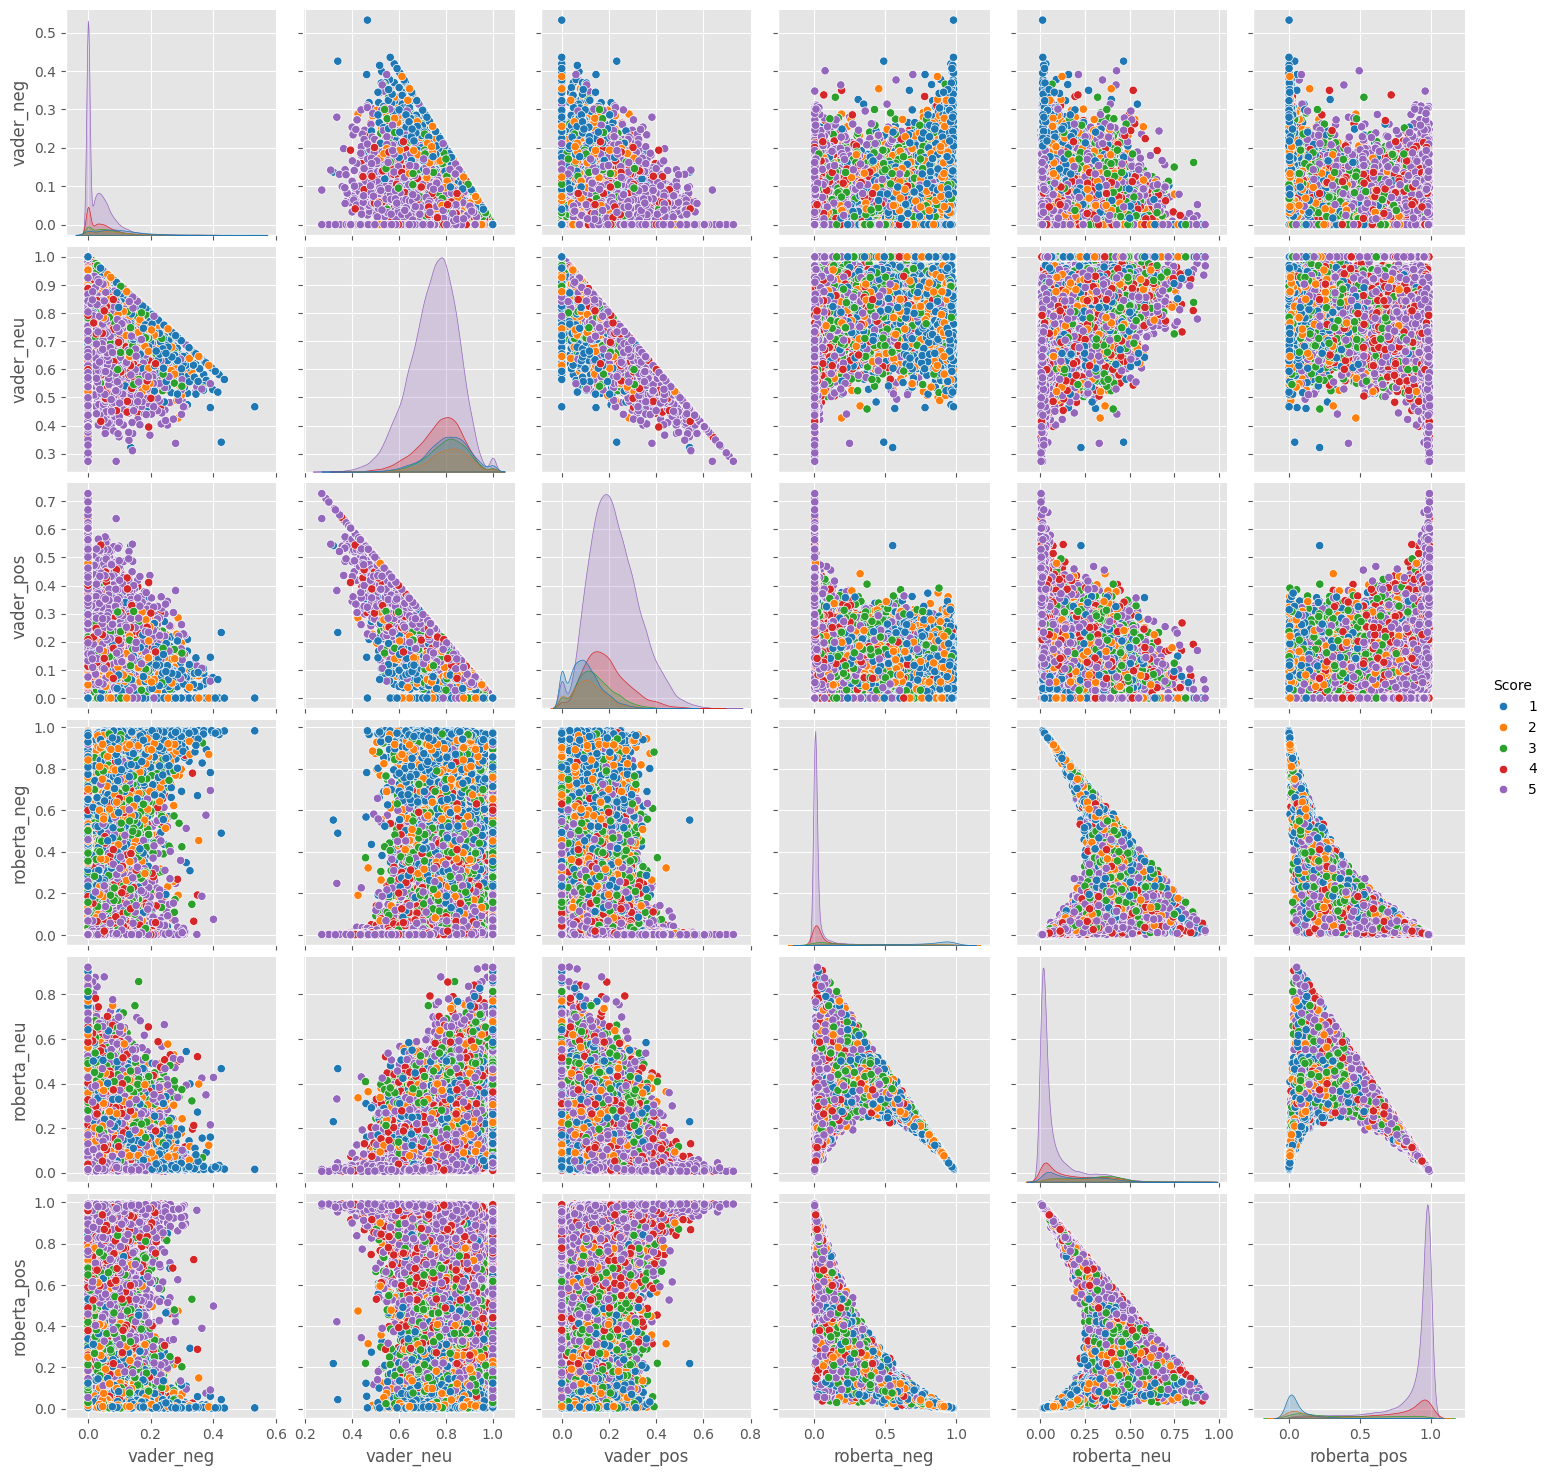

In [51]:
sns.pairplot(data=results, 
            vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
                  hue='Score',
                  palette='tab10')
plt.show()

In [52]:
ex2 = 'Children are a happy mistake. You donot want them but they are not the worst and bring colors to your life'
polarity_scores_roberta(ex2)

{'roberta_neg': np.float32(0.2828184),
 'roberta_neu': np.float32(0.4190762),
 'roberta_pos': np.float32(0.29810533)}

In [53]:
sia.polarity_scores(ex2)


{'neg': 0.066, 'neu': 0.624, 'pos': 0.31, 'compound': 0.7384}

## Transformers Pipeline

In [54]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [55]:
ex3 = "This was a overwhelmingly, dauntingly useful exercise"
sent_pipeline(ex3)

[{'label': 'POSITIVE', 'score': 0.9957426190376282}]

In [56]:
sia.polarity_scores(ex3)

{'neg': 0.179, 'neu': 0.476, 'pos': 0.345, 'compound': 0.34}

In [57]:
polarity_scores_roberta(ex3)

{'roberta_neg': np.float32(0.012402663),
 'roberta_neu': np.float32(0.117067285),
 'roberta_pos': np.float32(0.87053007)}